In [48]:
# ----------------------------------------------------------------------------
#
# TITLE - velocity_radial_profiles_dr16.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
# 
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''Examine the radial trends in velocity using DR16 data. Highlight the discrepency between
simple bar models and the data.
'''

__author__ = "James Lane"

In [49]:
## Imports

## Basic
import numpy as np
import sys, os, pdb
import copy
import time
from tqdm import tqdm_notebook as tqdm_nb

## Plotting
import matplotlib
from matplotlib import pyplot as plt

## Astropy
from astropy import units as apu
from astropy.io import fits

## Scipy
from scipy.stats import binned_statistic_2d, binned_statistic
from scipy.optimize import curve_fit

## Add project-specific package. Assume relative location
sys.path.append('../../src/')
import ast1501.util
import ast1501.fourier
import ast1501.linear_model

In [50]:
# Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Meta

## Future work

## Information
- Galpy notes on the DF: https://galpy.readthedocs.io/en/latest/diskdf.html
- Galpy notes on the actions: https://galpy.readthedocs.io/en/latest/actionAngle.html

# Prepare
Declare the keywords for the analysis, make the potential, and the DF

## Keywords and File Names for Gaia

In [51]:
n_bs = 100

In [52]:
### Load catalogs
gaiadr2_apogee_catalog = '../../data/generated/gaiadr2-apogee_dr16_dataset.FIT'
f = fits.open(gaiadr2_apogee_catalog)
data = f[1].data

In [53]:
### Cut on galactocentric absolute Z < 0.3 kpc
where_low_z = np.where( np.abs(data['Z']) < 0.3 )[0]
data_low_z = data[where_low_z] 
z_select_text = r'$|$Z$_{GC}| < 0.3$ kpc'

In [54]:
### Read catalog values

# ID, RA, Dec, logg, abundances, errors
apid = data_low_z['APOGEE_ID']
locid = data_low_z['LOCATION_ID']
vhelio = data_low_z['VHELIO']
gc_R = data_low_z['R']
gc_phi = data_low_z['PHI']
gc_z = data_low_z['Z']
gc_vR = data_low_z['VR']
gc_vT = data_low_z['VT']
gc_vz = data_low_z['VZ']

# Adjust the phi velocities 
gc_phi[ np.where( (gc_phi > np.pi) ) ] -= 2*np.pi

## Set the grid parameters

In [55]:
# Radial bin range and size
R_lim = [5,15]
R_bin_size = 1.0
R_bin_cents = np.arange( R_lim[0], R_lim[1], R_bin_size ) + R_bin_size/2

# Phi bin range and size
phi_lim = [-np.pi/2, np.pi/2]
phi_bin_size = np.pi/30
phi_bin_cents = np.arange( phi_lim[0], phi_lim[1], phi_bin_size ) + phi_bin_size/2

# Phib bin range and size
phib_lim = [0, np.pi/2]
phib_bin_size = np.pi/60
phib_bin_cents = np.arange( phib_lim[0], phib_lim[1], phib_bin_size ) + phi_bin_size/2
vT_prior_path='../../data/linear_model_prior/MWPotential2014_df_vT_data.npy'

In [85]:
lm = ast1501.linear_model.LinearModel2(instantiate_method=1, gc_R=gc_R, 
    gc_phi=gc_phi, gc_vR=gc_vR, gc_vT=gc_vT, R_lims=R_lim, 
    R_bin_size=R_bin_size, phi_lims=phi_lim, 
    phi_bin_size=phi_bin_size, phib_lims=phib_lim,
    phib_bin_size=phib_bin_size, fit_yint_vR_constant=True,
    vT_prior_path='../../data/linear_model_prior/MWPotential2014_df_vT_data.npy')

lm_vR = ast1501.linear_model.LinearModel2(instantiate_method=1, gc_R=gc_R, 
    gc_phi=gc_phi, gc_vR=gc_vR, gc_vT=gc_vT, R_lims=R_lim, 
    R_bin_size=R_bin_size, phi_lims=phi_lim, 
    phi_bin_size=phi_bin_size, phib_lims=phib_lim,
    phib_bin_size=phib_bin_size, fit_yint_vR_constant=True,
    use_velocities=['vR',],
    vT_prior_path='../../data/linear_model_prior/MWPotential2014_df_vT_data.npy')

Warning, fitting y-intercept constant across all radial bins, ignoring forced y-intercept value...
Warning, fitting y-intercept constant across all radial bins, ignoring forced y-intercept value...


## Tangential Velocity

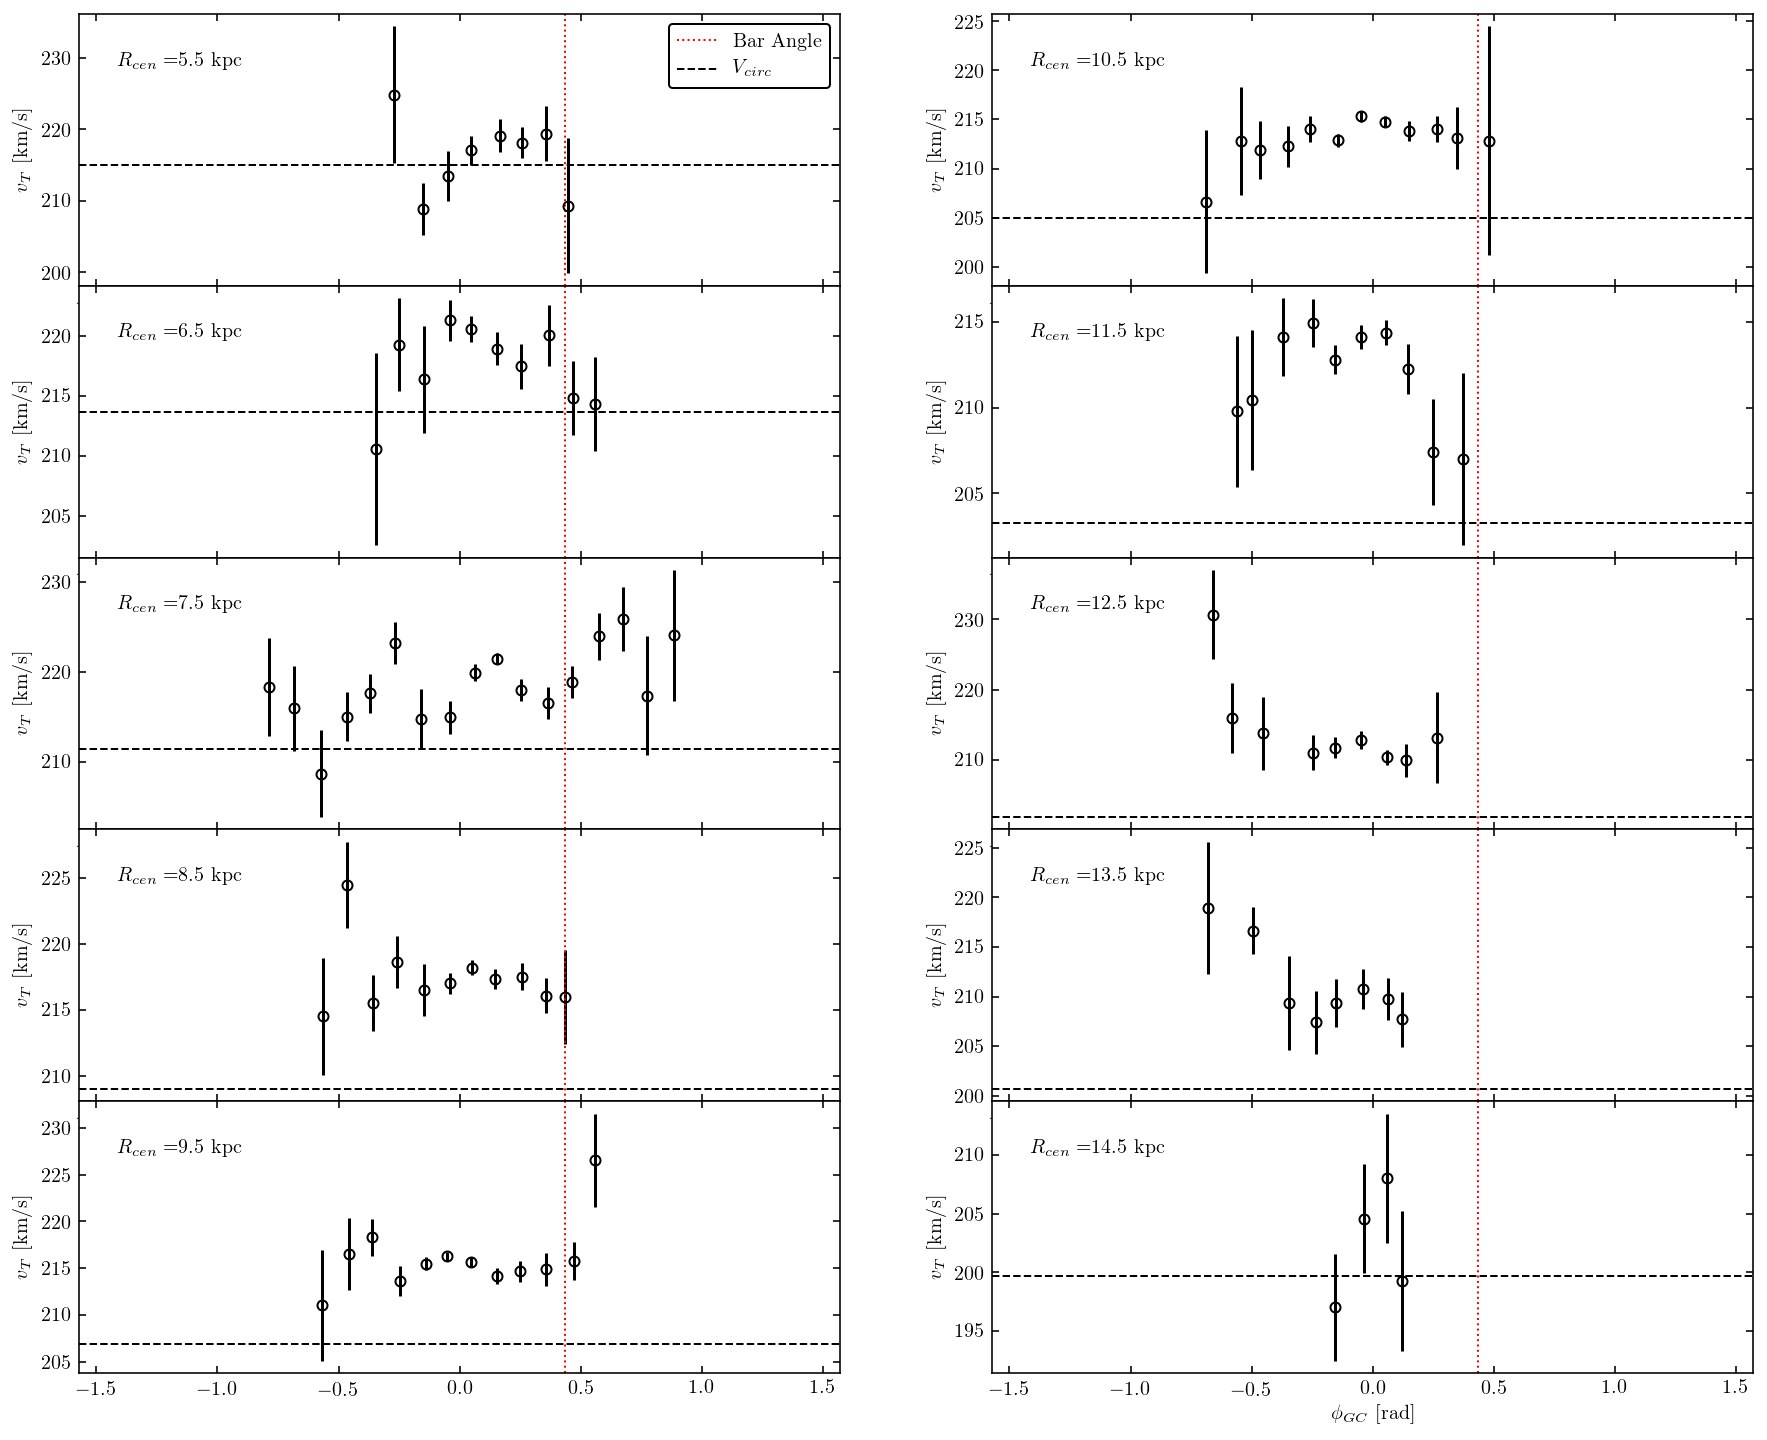

In [57]:
fig,axs = lm.plot_velocity_known_m_b_phi(velocity_type='vT',plot_best_fit=False, )
axs[-1].set_xlabel(r'$\phi_{GC}$ [rad]')
fig.set_facecolor('White')
plt.show()

# Radial Velocity

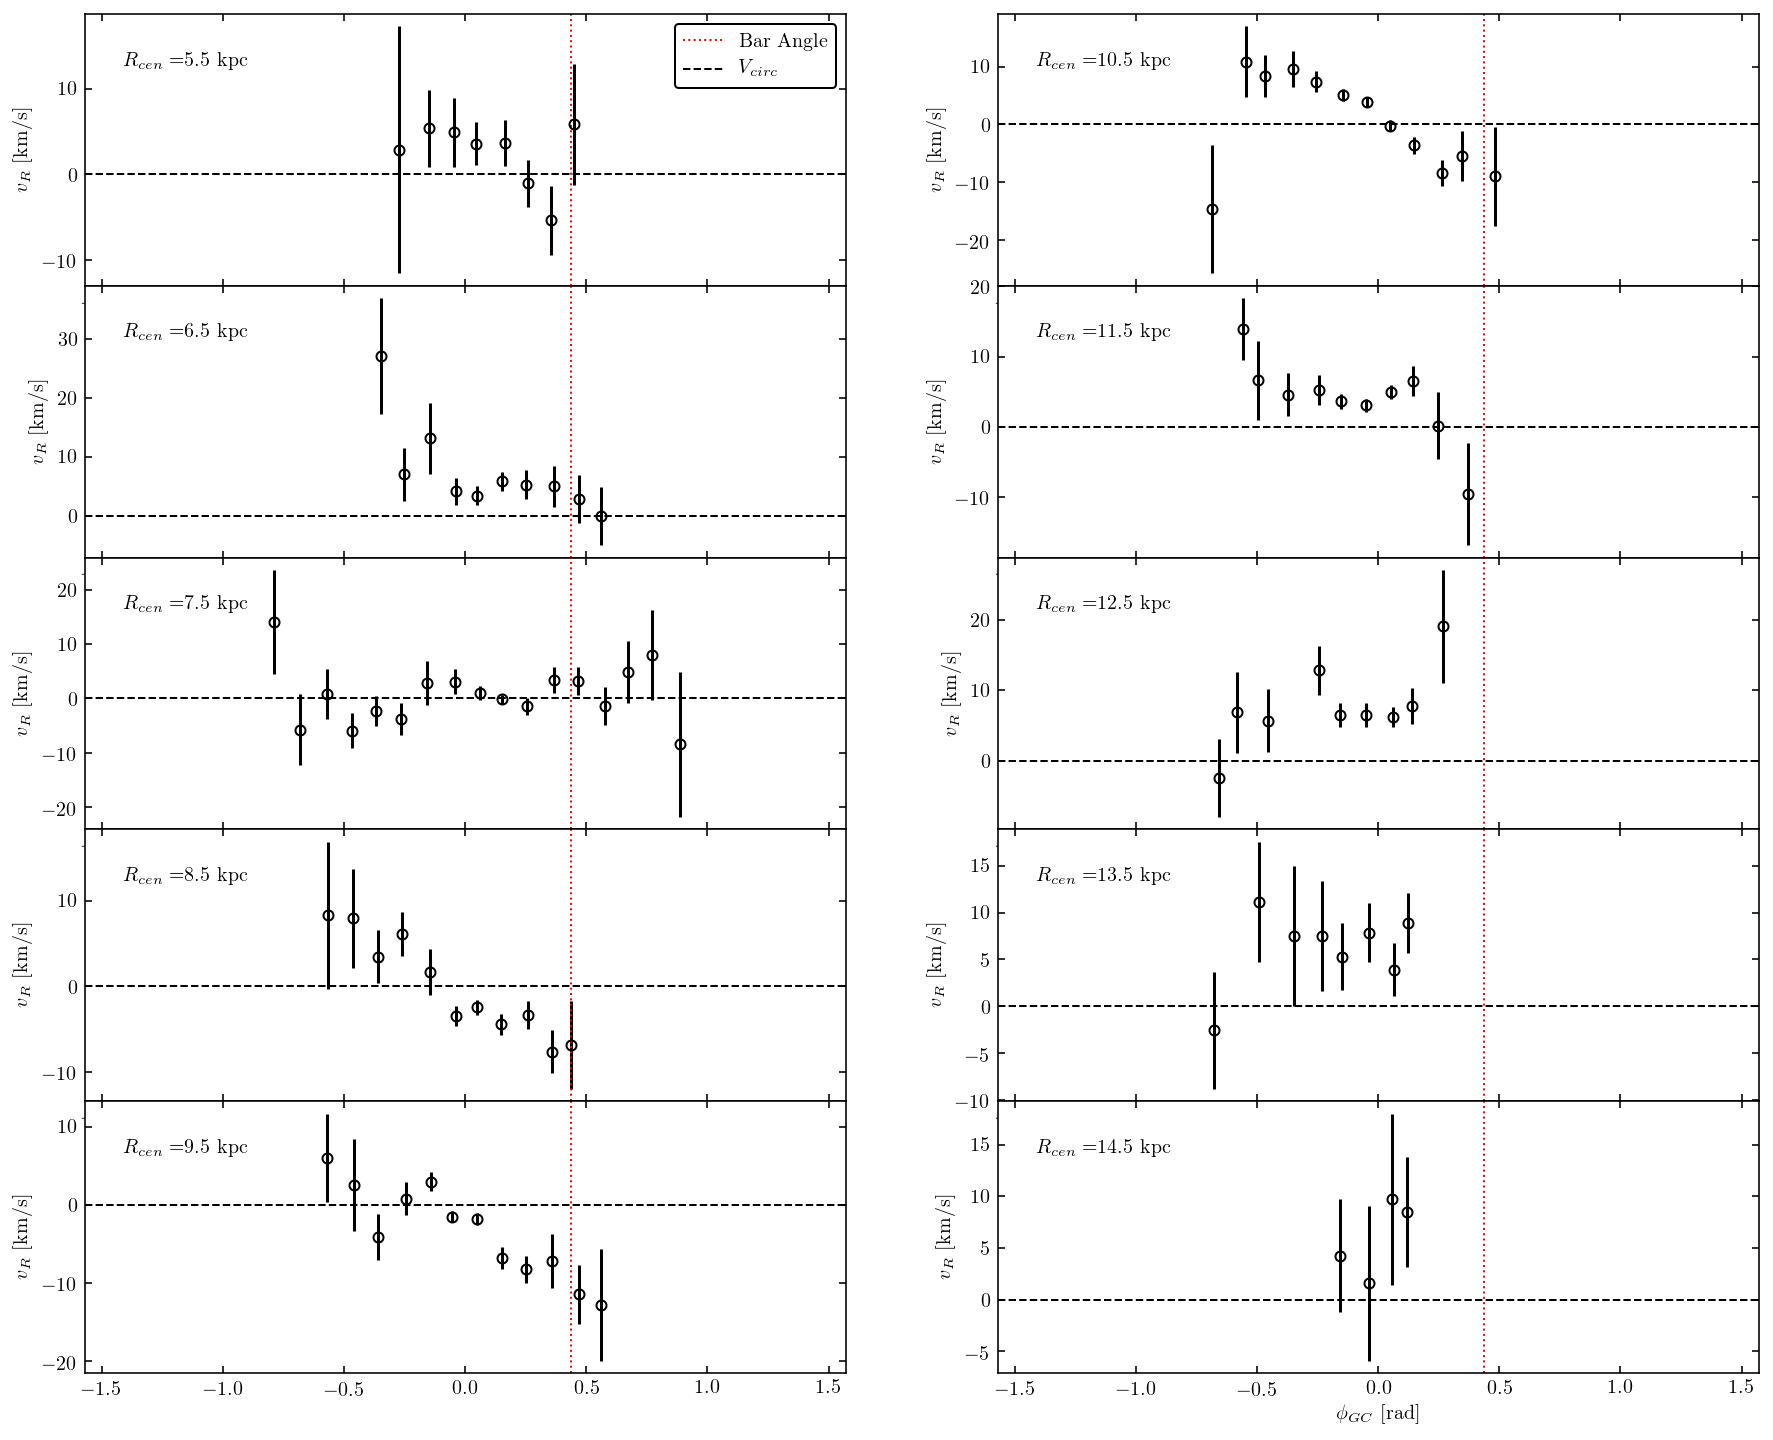

In [58]:
fig,axs = lm.plot_velocity_known_m_b_phi(velocity_type='vR',plot_best_fit=False)
axs[-1].set_xlabel(r'$\phi_{GC}$ [rad]')
fig.set_facecolor('White')
plt.show()

# Include some bars

In [59]:
lm_sfb = ast1501.linear_model.LinearModel2(instantiate_method=2, 
    df_filename='../../scripts/dehnen_method/bar_df/2019-05-20/data.npy', 
    phib_bin_size=phib_bin_size, phib_lims=phib_lim, 
    vT_prior_path=vT_prior_path)
lm_lsb = ast1501.linear_model.LinearModel2(instantiate_method=2, 
        df_filename='../../scripts/dehnen_method/lsbar_df/2019-05-27/data.npy', 
        phib_bin_size=phib_bin_size, phib_lims=phib_lim,
        vT_prior_path=vT_prior_path)

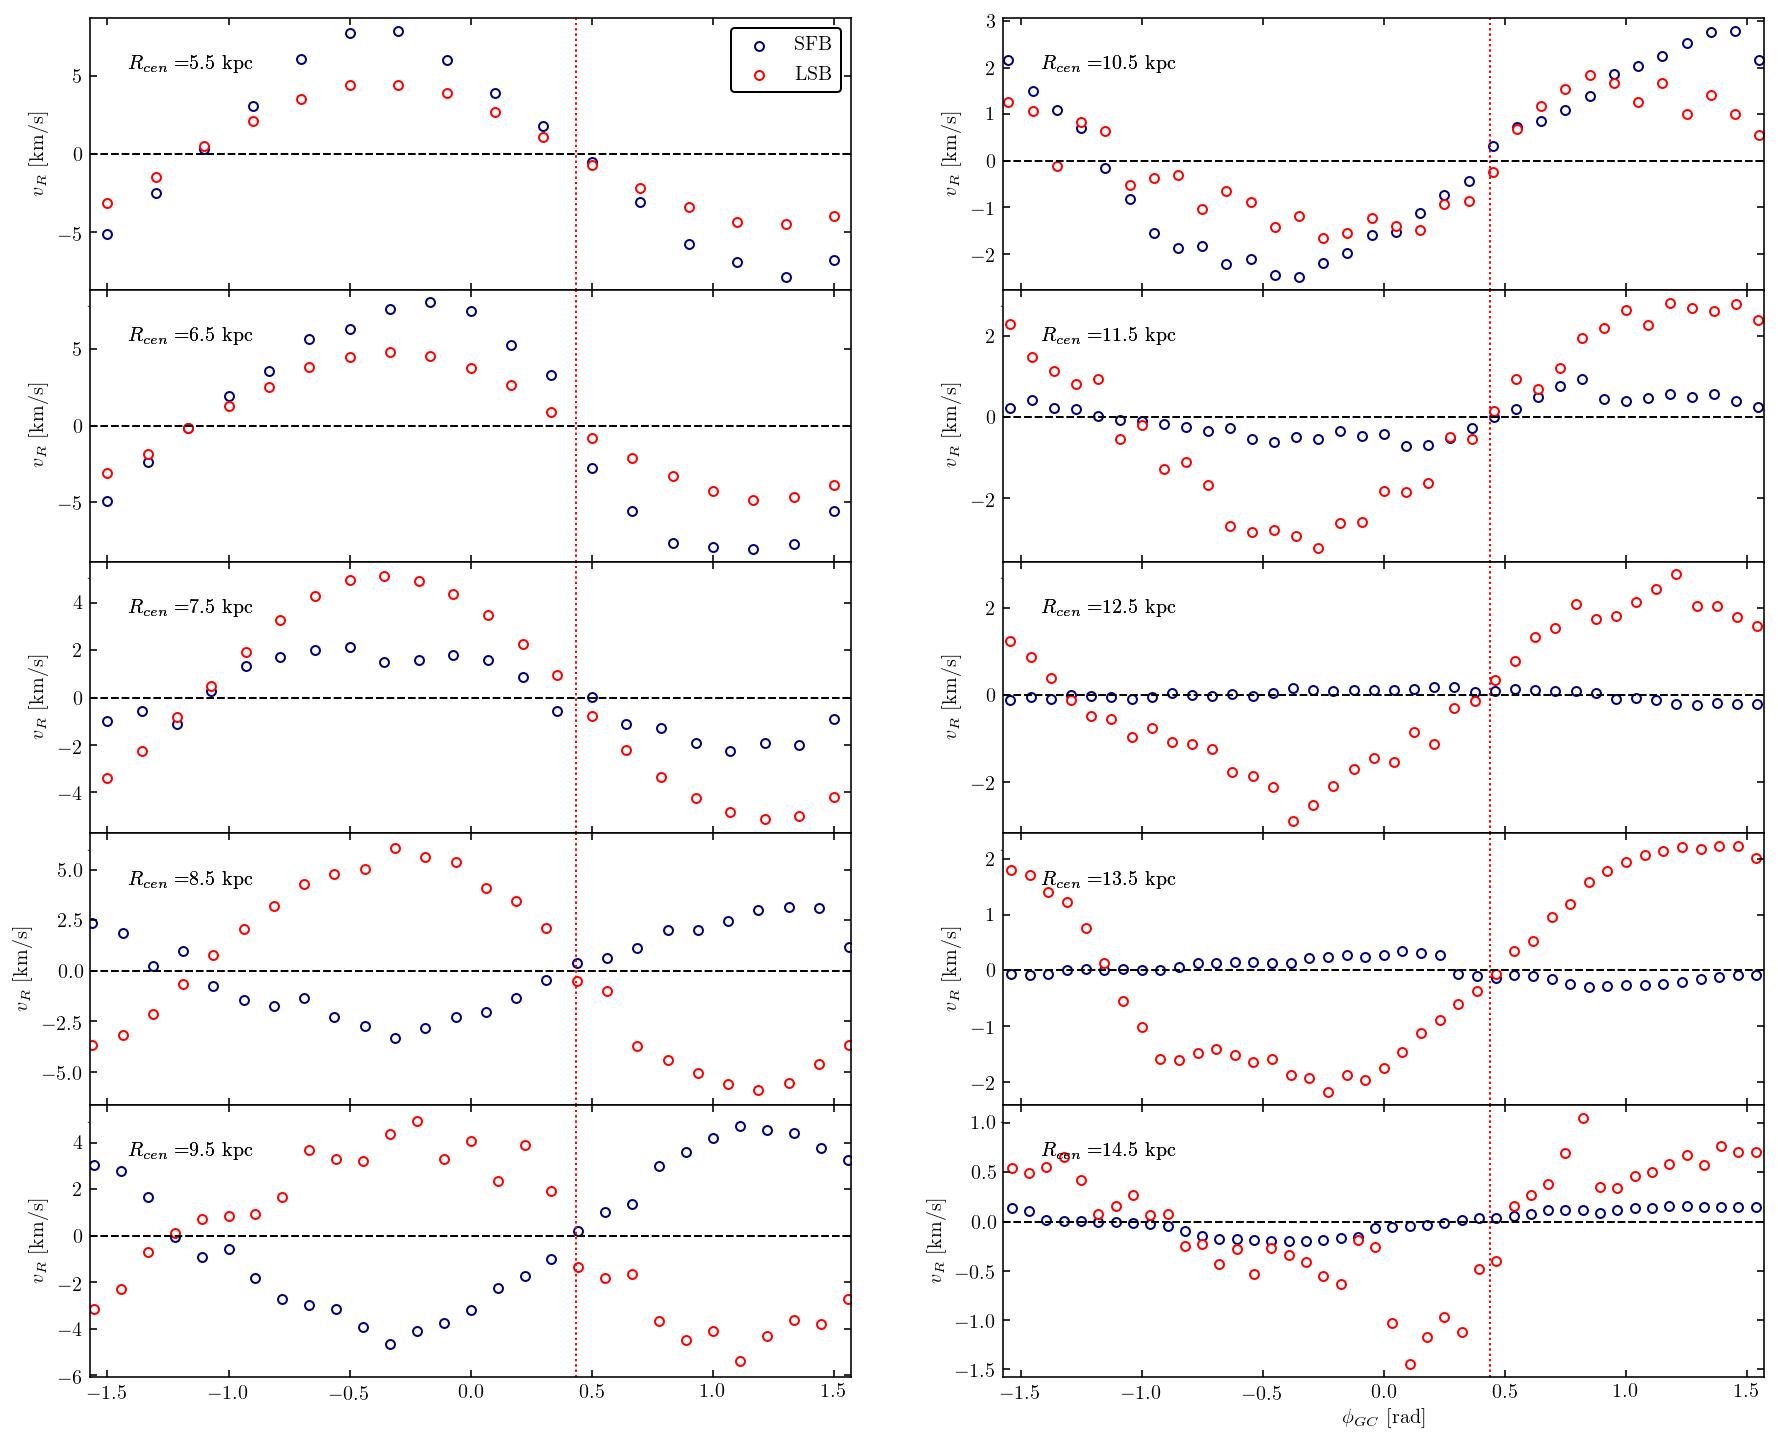

In [60]:
plot_kws_sfb={'facecolor':'White', 'edgecolor':'Navy', 's':20}
fig,axs = lm_sfb.plot_velocity_known_m_b_phi(velocity_type='vR', plot_best_fit=False, 
                                             plot_errs=False, plot_kws=plot_kws_sfb, 
                                             twocolumn=True)

plot_kws_lsb={'facecolor':'White', 'edgecolor':'Red', 's':20}
fig,axs = lm_lsb.plot_velocity_known_m_b_phi(velocity_type='vR', plot_best_fit=False, 
                                             plot_errs=False, plot_kws=plot_kws_lsb, fig=fig, 
                                             axs=axs)

axs[0].get_legend().remove()
sfb_pts=axs[0].scatter([],[],**plot_kws_sfb)
lsb_pts=axs[0].scatter([],[],**plot_kws_lsb)
axs[0].legend(handles=[sfb_pts,lsb_pts], labels=['SFB','LSB'], loc='best')
axs[-1].set_xlabel(r'$\phi_{GC}$ [rad]')
fig.set_facecolor('White')

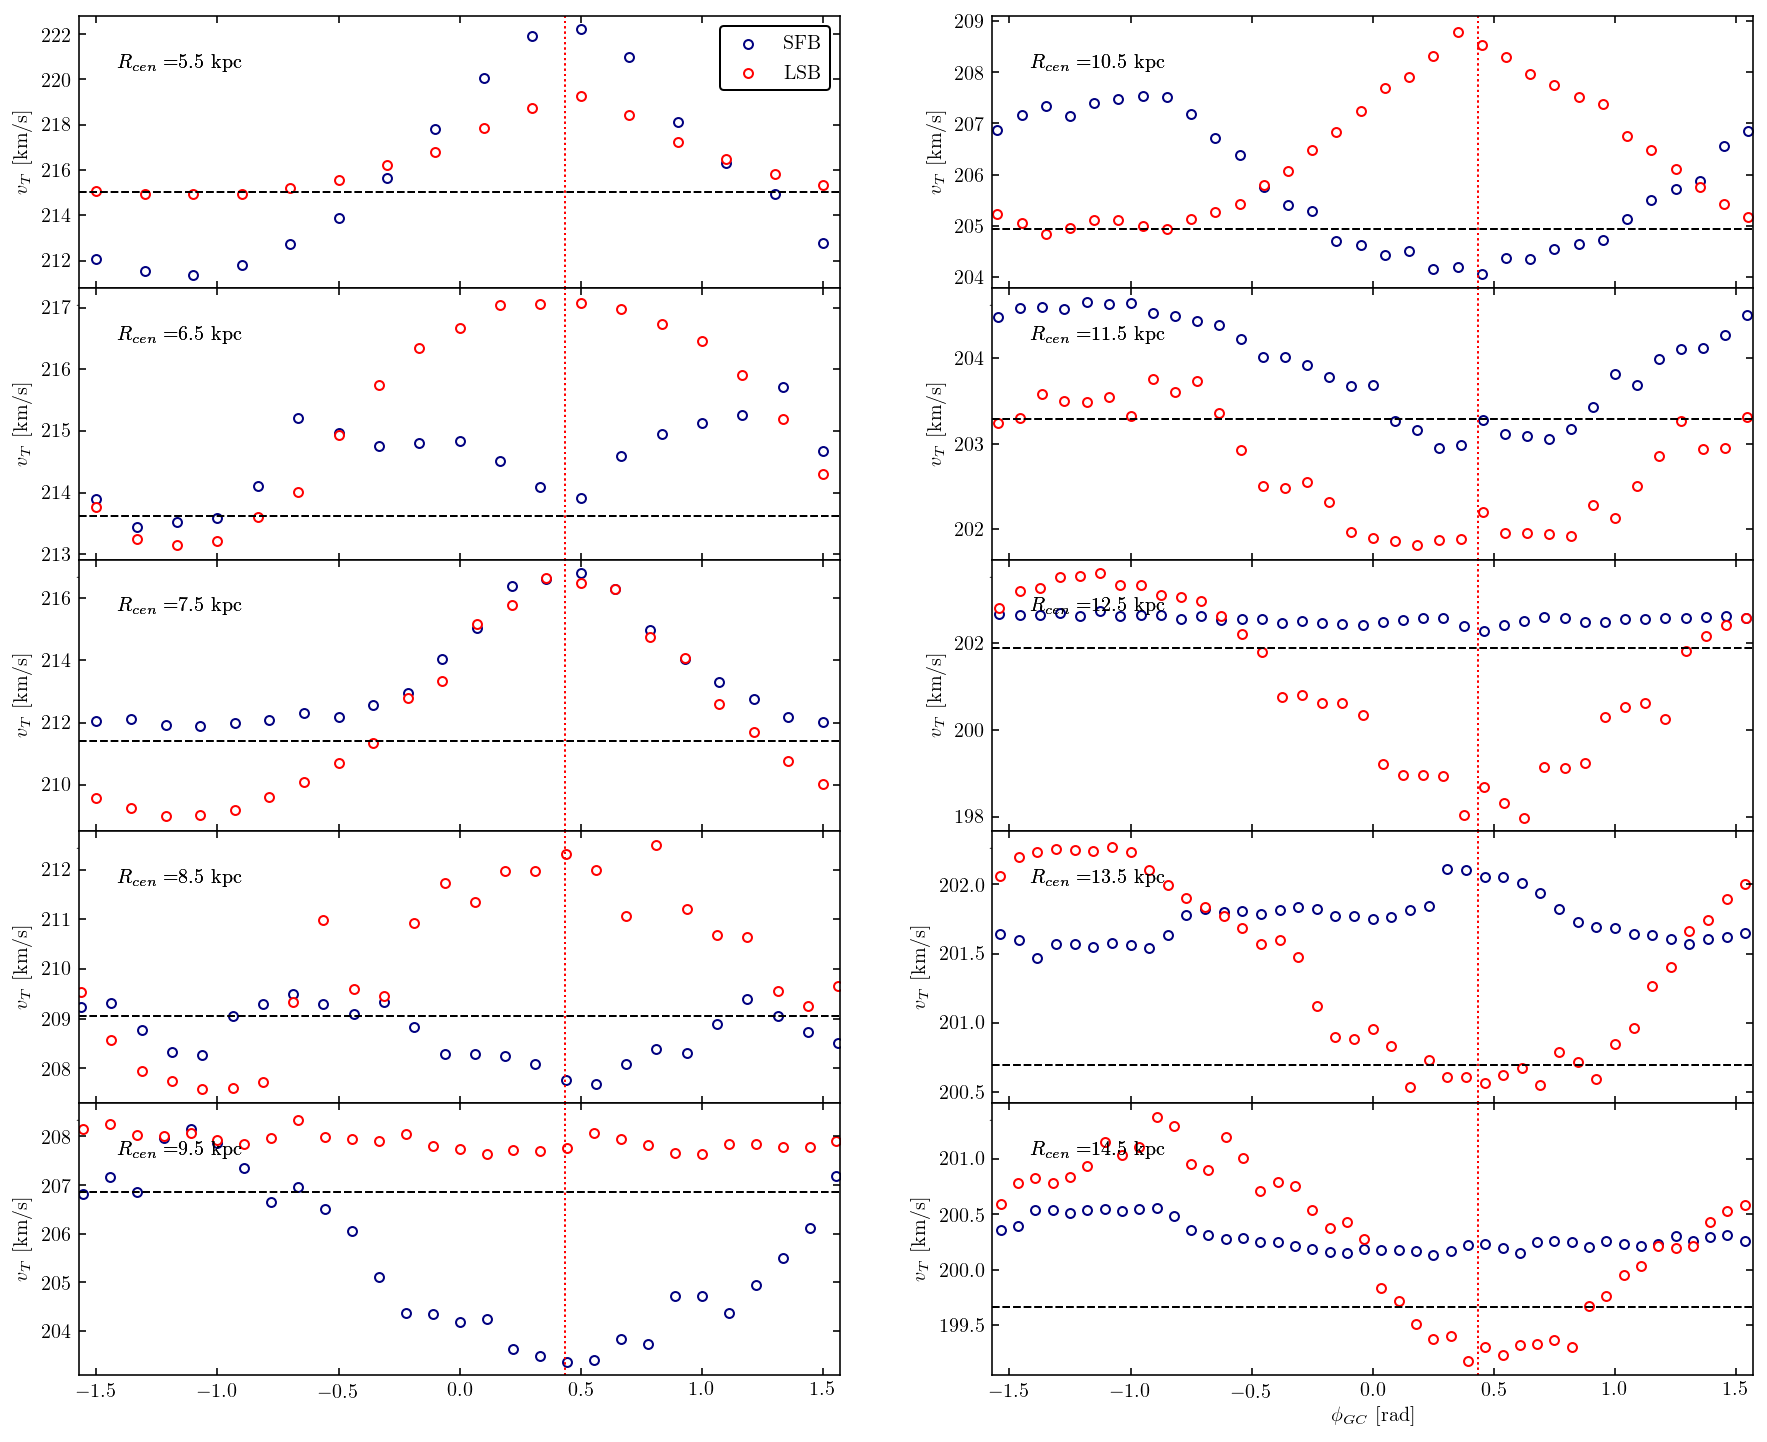

In [61]:
plot_kws_sfb={'facecolor':'White', 'edgecolor':'Navy', 's':20}
fig,axs = lm_sfb.plot_velocity_known_m_b_phi(velocity_type='vT', plot_best_fit=False, 
                                             plot_errs=False, plot_kws=plot_kws_sfb)

plot_kws_lsb={'facecolor':'White', 'edgecolor':'Red', 's':20}
fig,axs = lm_lsb.plot_velocity_known_m_b_phi(velocity_type='vT', plot_best_fit=False, 
                                             plot_errs=False, plot_kws=plot_kws_lsb, fig=fig, 
                                             axs=axs)

axs[0].get_legend().remove()
sfb_pts=axs[0].scatter([],[],**plot_kws_sfb)
lsb_pts=axs[0].scatter([],[],**plot_kws_lsb)
axs[0].legend(handles=[sfb_pts,lsb_pts], labels=['SFB','LSB'], loc='best')
axs[-1].set_xlabel(r'$\phi_{GC}$ [rad]')
fig.set_facecolor('White')

# Show with the data

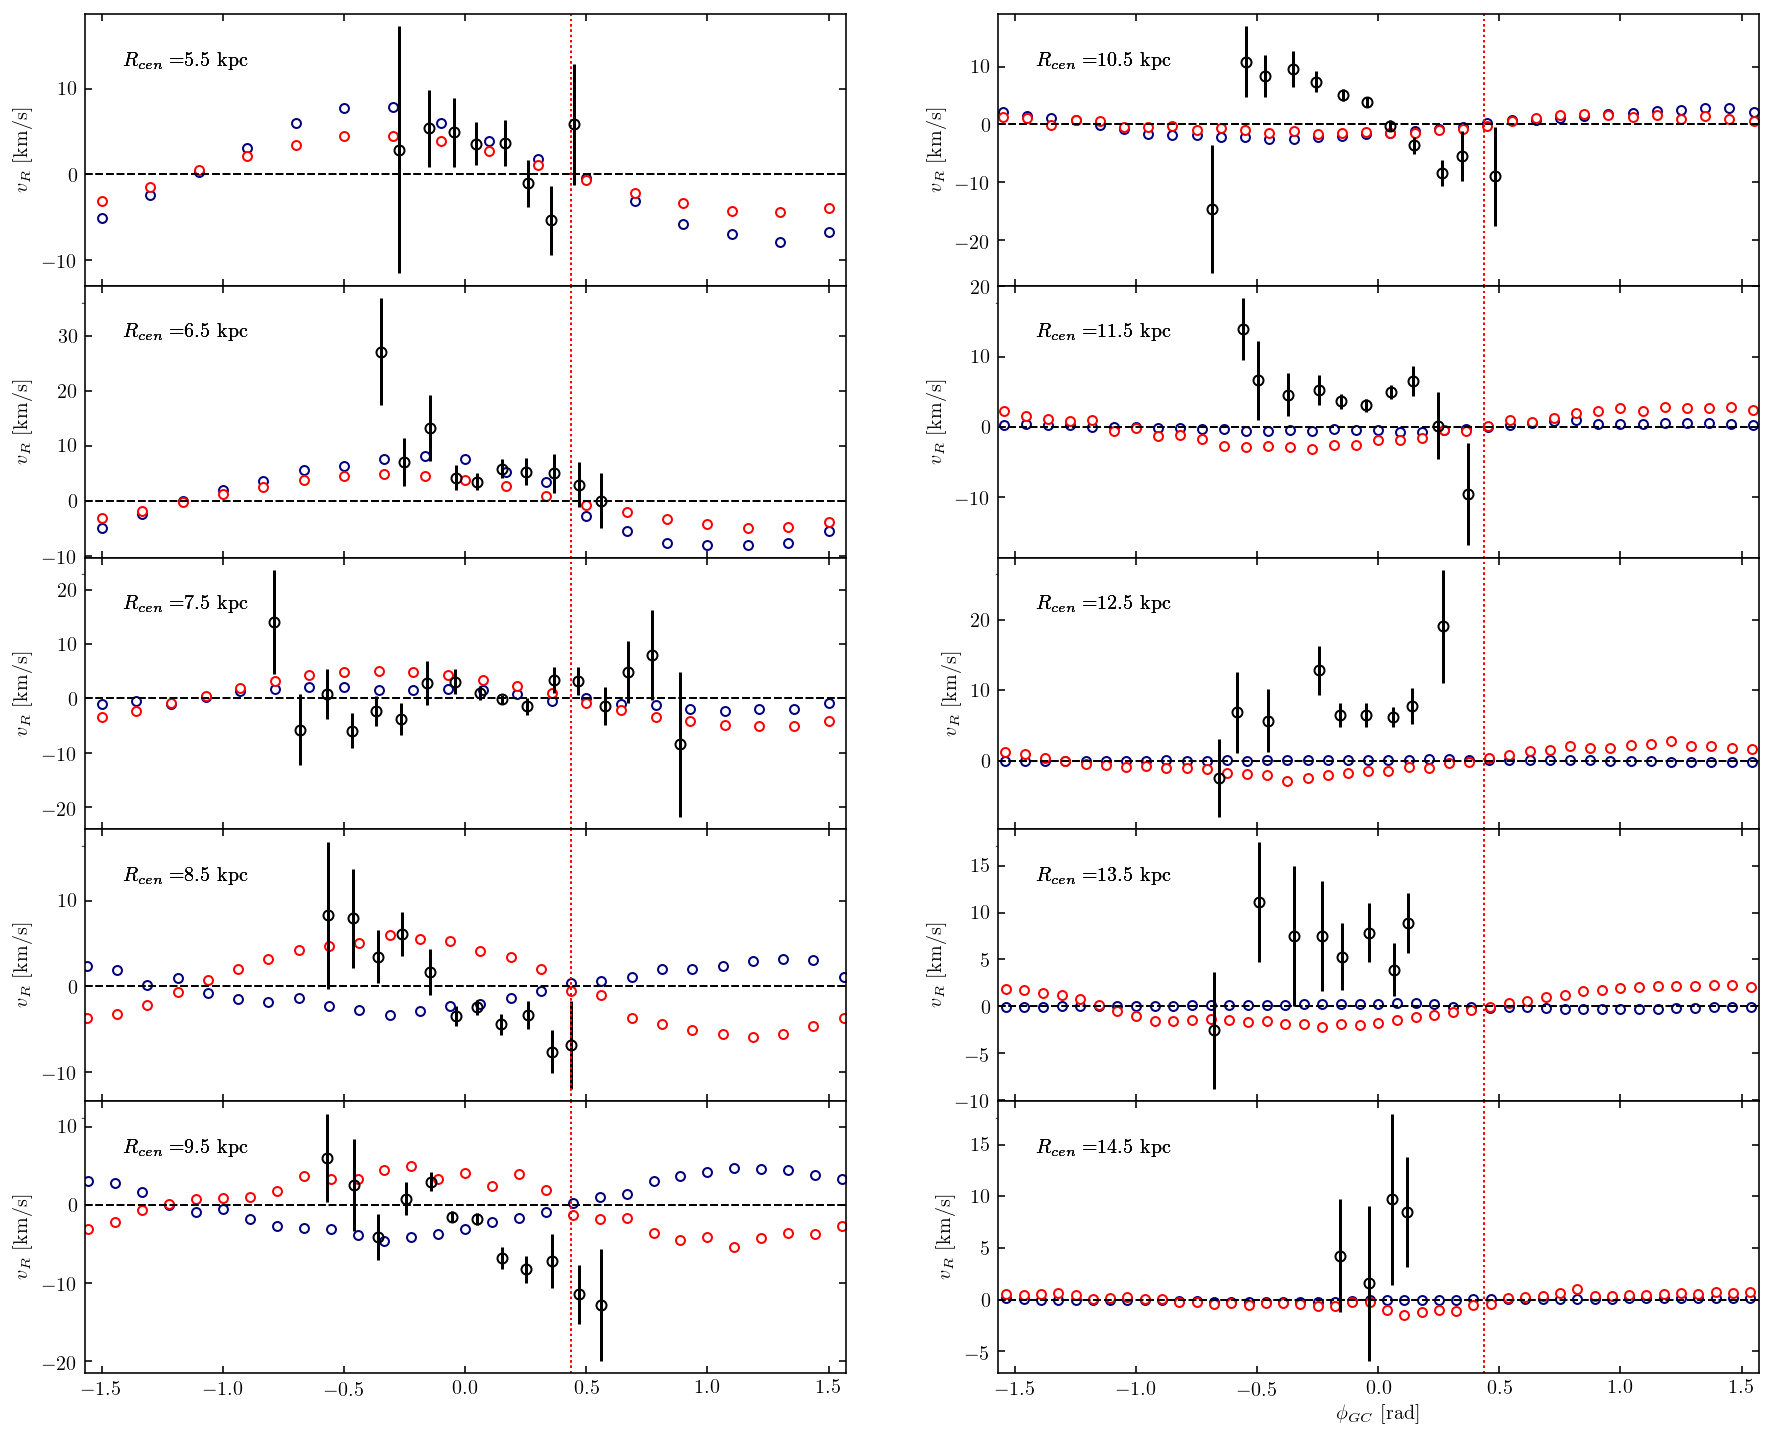

In [62]:
plot_kws_sfb={'facecolor':'White', 'edgecolor':'Navy', 's':20}
fig,axs = lm_sfb.plot_velocity_known_m_b_phi(velocity_type='vR', plot_best_fit=False, 
                                             plot_errs=False, plot_kws=plot_kws_sfb)

plot_kws_lsb={'facecolor':'White', 'edgecolor':'Red', 's':20}
fig,axs = lm_lsb.plot_velocity_known_m_b_phi(velocity_type='vR', plot_best_fit=False, 
                                             plot_errs=False, plot_kws=plot_kws_lsb, fig=fig, 
                                             axs=axs)

fig,axs = lm.plot_velocity_known_m_b_phi(velocity_type='vR',plot_best_fit=False, 
                                         fig=fig, axs=axs)

axs[0].get_legend().remove()
axs[-1].set_xlabel(r'$\phi_{GC}$ [rad]')
fig.set_facecolor('White')

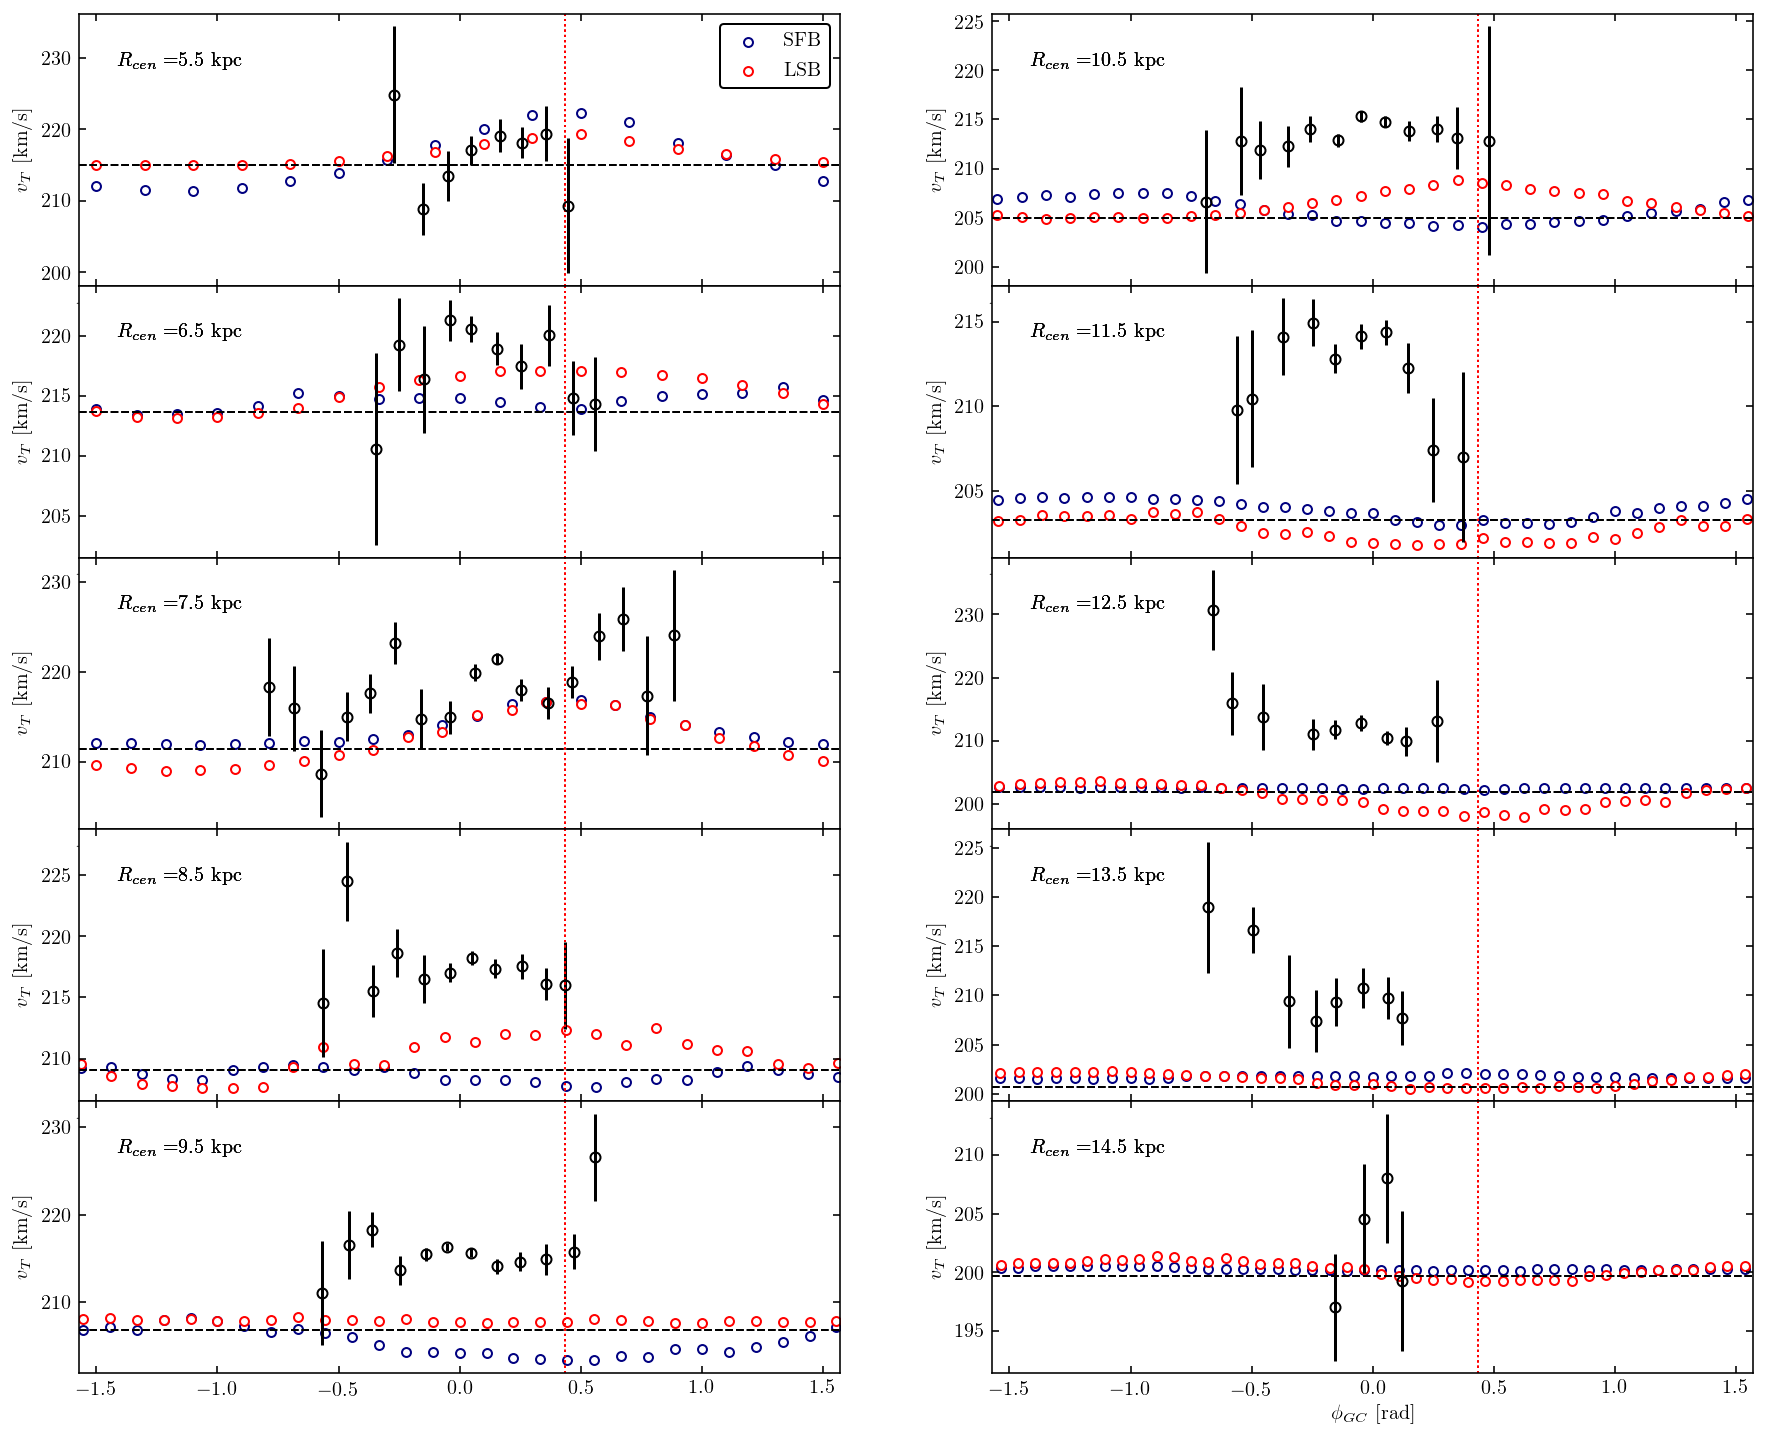

In [63]:
plot_kws_sfb={'facecolor':'White', 'edgecolor':'Navy', 's':20}
fig,axs = lm_sfb.plot_velocity_known_m_b_phi(velocity_type='vT', plot_best_fit=False, 
                                             plot_errs=False, plot_kws=plot_kws_sfb)

plot_kws_lsb={'facecolor':'White', 'edgecolor':'Red', 's':20}
fig,axs = lm_lsb.plot_velocity_known_m_b_phi(velocity_type='vT', plot_best_fit=False, 
                                             plot_errs=False, plot_kws=plot_kws_lsb, fig=fig, 
                                             axs=axs)

fig,axs = lm.plot_velocity_known_m_b_phi(velocity_type='vT',plot_best_fit=False, 
                                         fig=fig, axs=axs)

axs[0].get_legend().remove()
sfb_pts=axs[0].scatter([],[],**plot_kws_sfb)
lsb_pts=axs[0].scatter([],[],**plot_kws_lsb)
axs[0].legend(handles=[sfb_pts,lsb_pts], labels=['SFB','LSB'], loc='best')
axs[-1].set_xlabel(r'$\phi_{GC}$ [rad]')
fig.set_facecolor('White')

# Include a triaxial halo

In [64]:
lm_th = ast1501.linear_model.LinearModel2(instantiate_method=2, 
        df_filename='../../scripts/dehnen_method/triaxial_df/2019-03-30/data0.npy', 
        phib_bin_size=phib_bin_size, phib_lims=phib_lim,
        vT_prior_path=vT_prior_path)

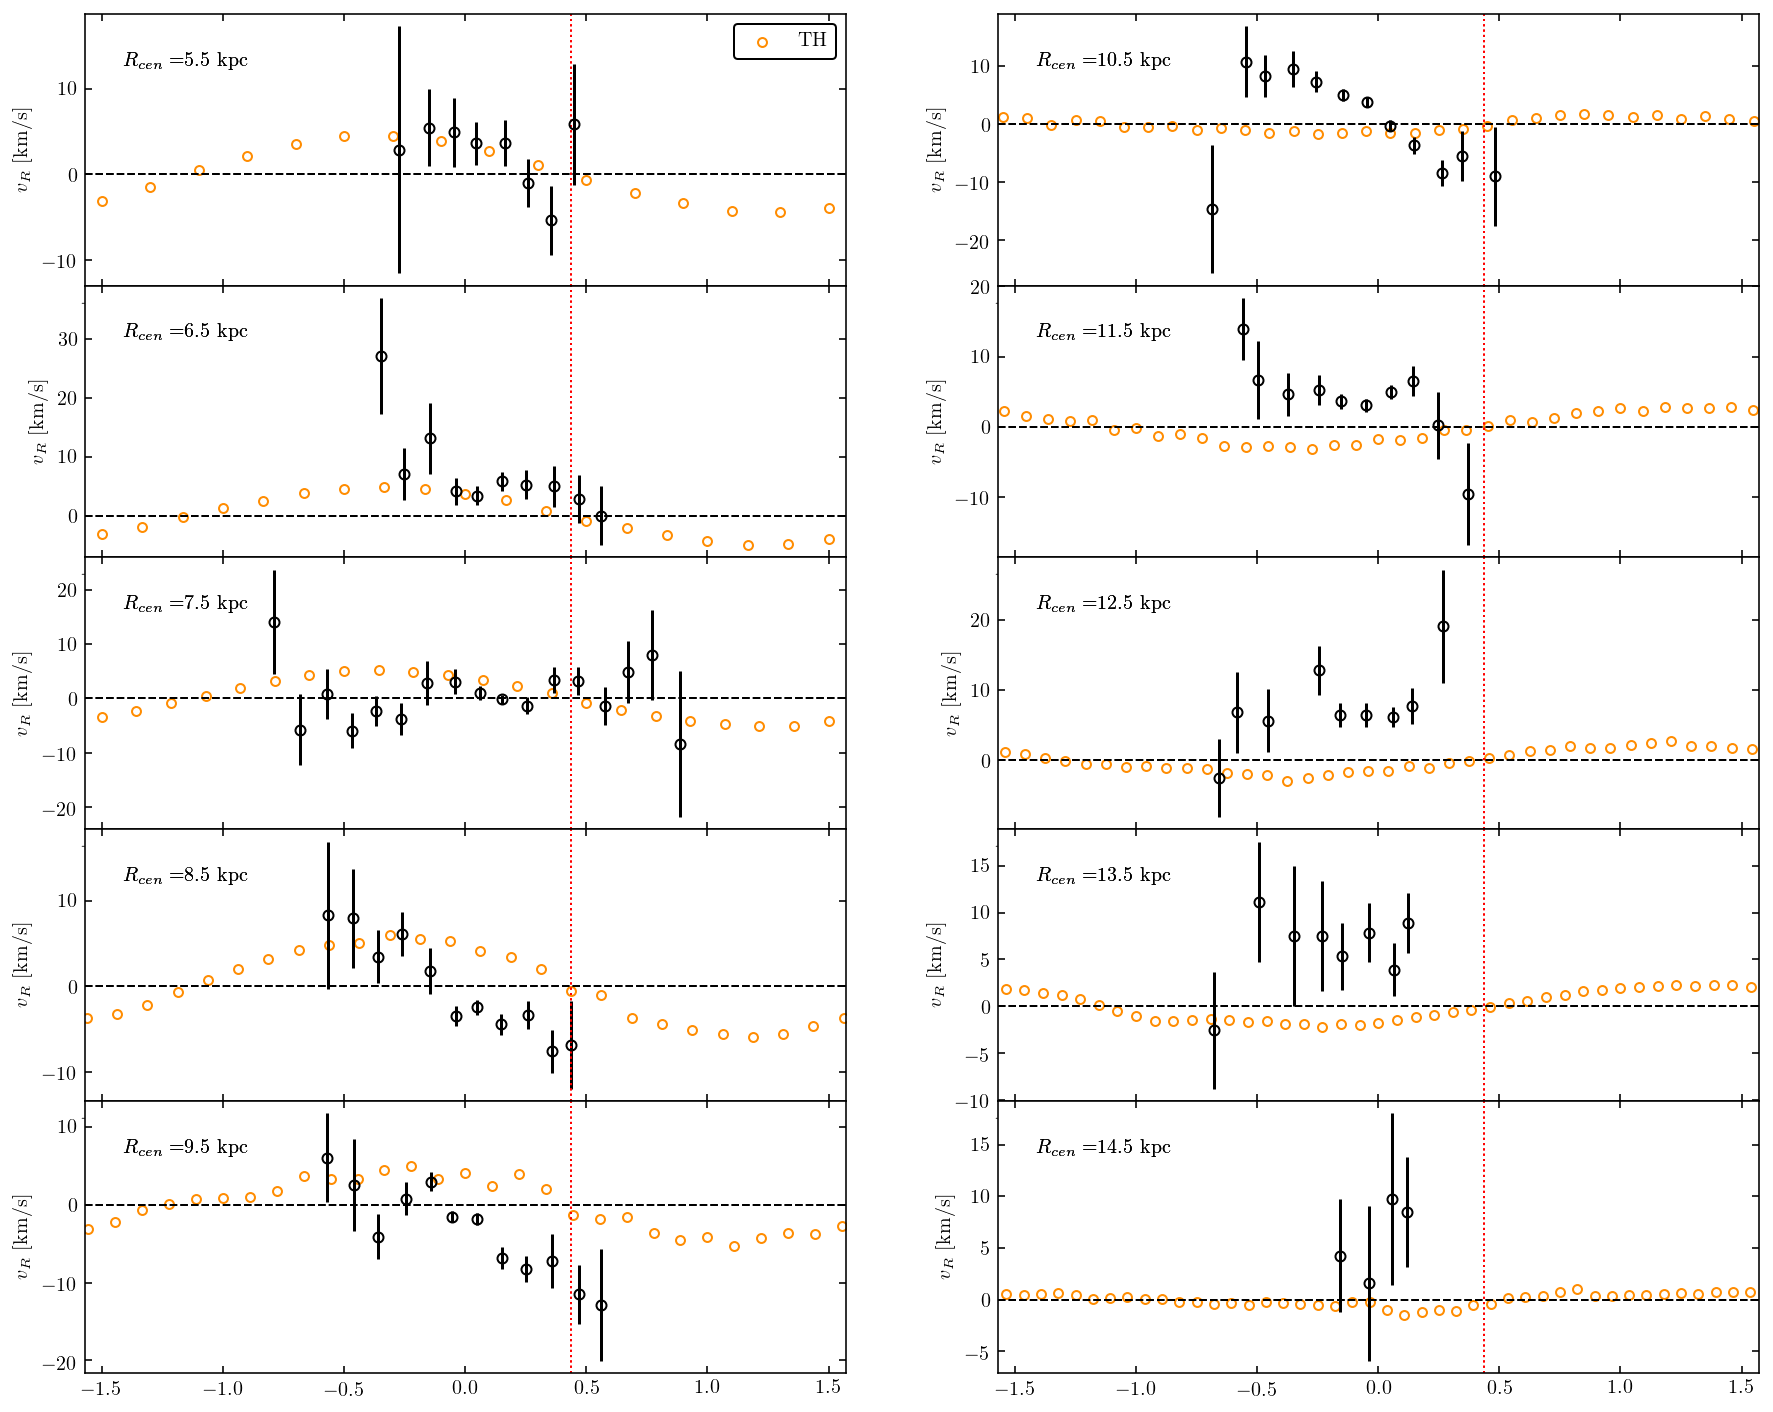

In [65]:
plot_kws_th={'facecolor':'White', 'edgecolor':'DarkOrange', 's':20}
fig,axs = lm_lsb.plot_velocity_known_m_b_phi(velocity_type='vR', plot_best_fit=False, 
                                             plot_errs=False, plot_kws=plot_kws_th)

fig,axs = lm.plot_velocity_known_m_b_phi(velocity_type='vR',plot_best_fit=False, 
                                         fig=fig, axs=axs)

fig.set_facecolor('White')
axs[0].get_legend().remove()
th_pts=axs[0].scatter([],[],**plot_kws_th)
axs[0].legend(handles=[th_pts], labels=['TH'], loc='best')

# Transient winding spiral structure

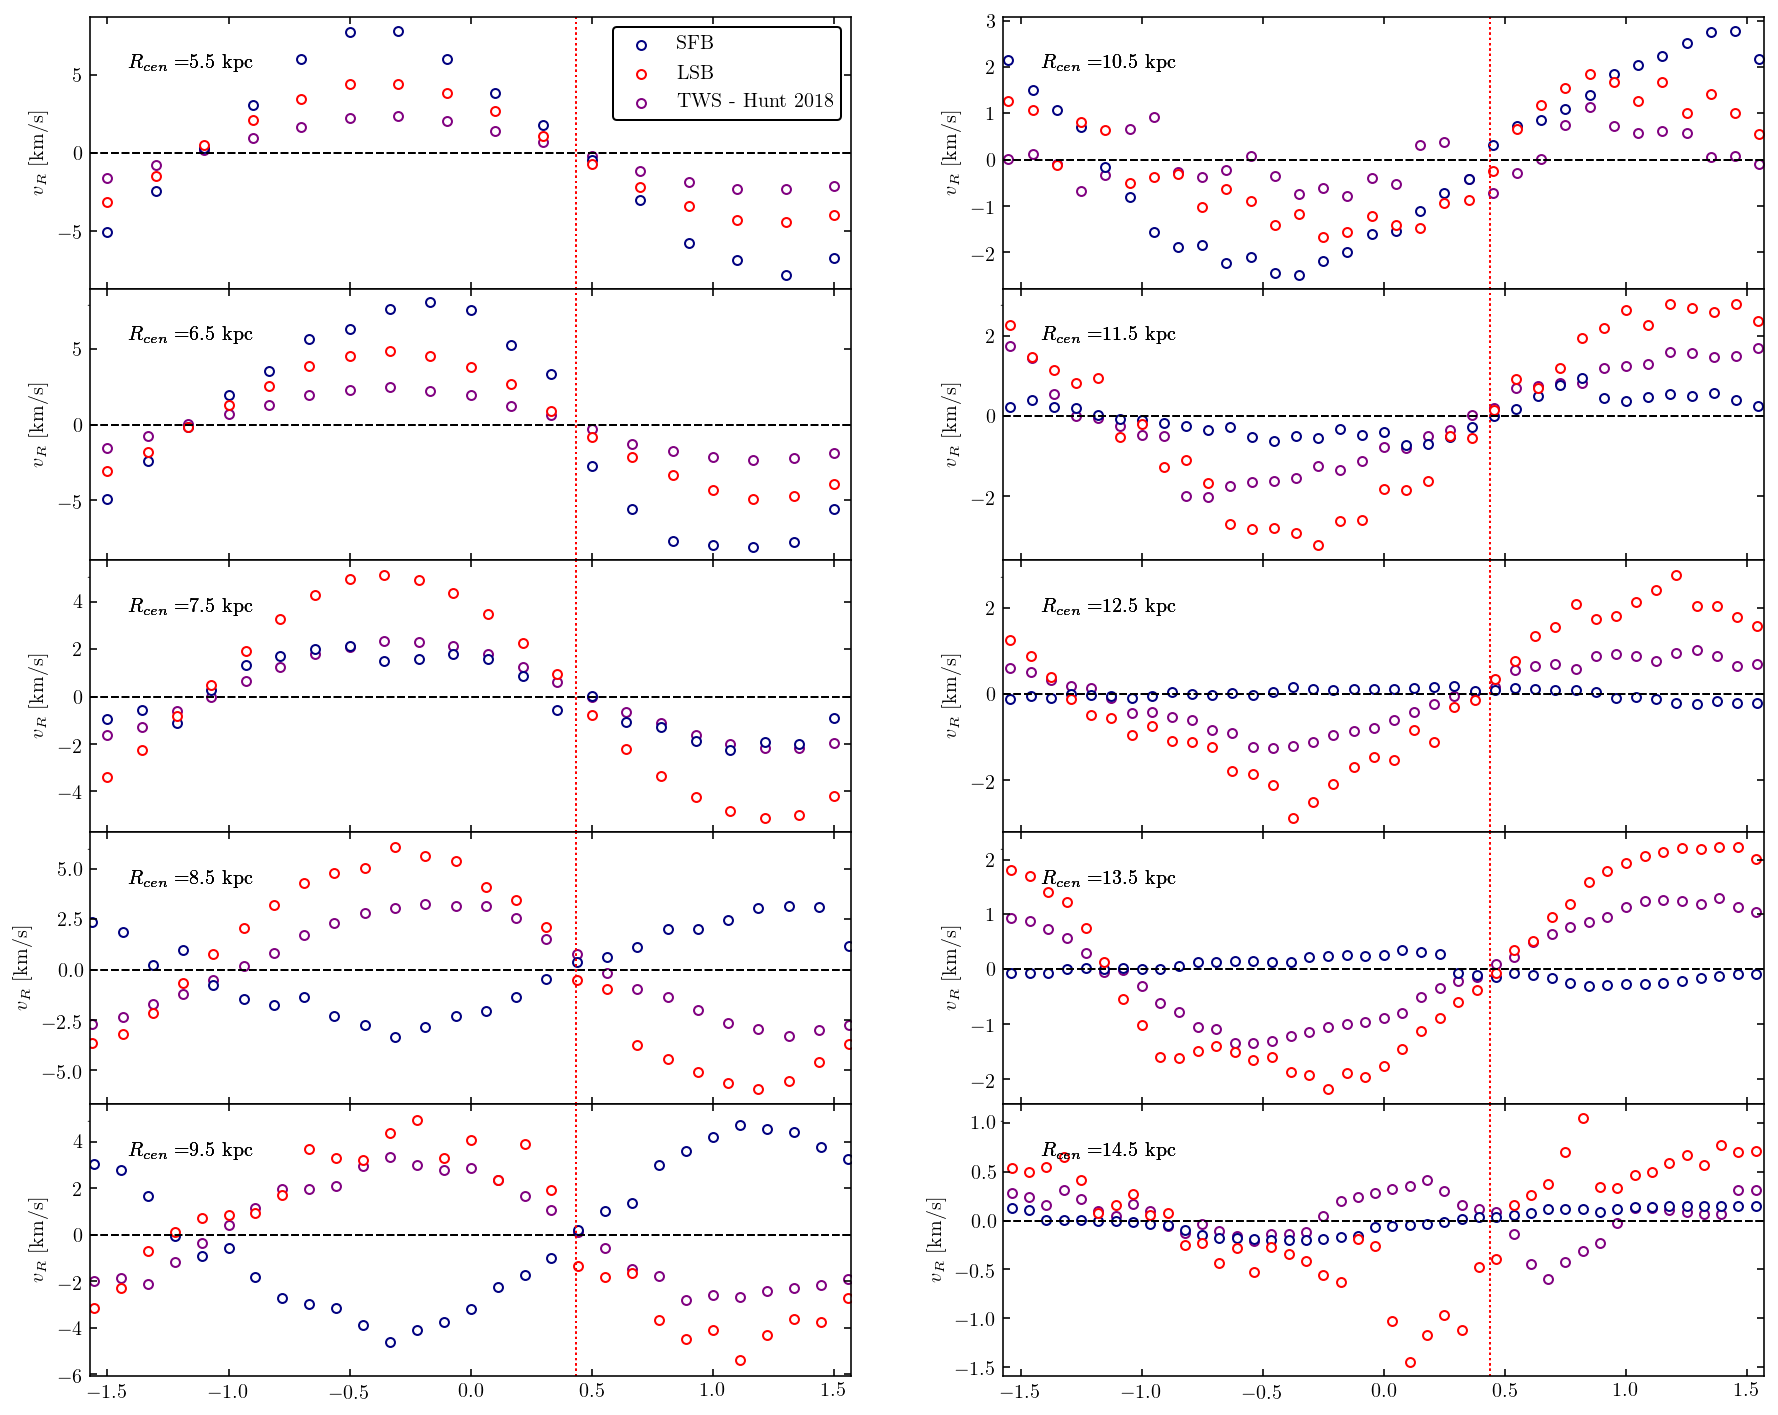

In [66]:
plot_kws_tws={'facecolor':'White', 'edgecolor':'Purple', 's':20}
lm_tws = ast1501.linear_model.LinearModel2(instantiate_method=2, 
         df_filename='../../scripts/dehnen_method/hunt_transient_winding_spiral_df/2020-02-11/data_HUNT_MODEL.npy', 
         phib_bin_size=phib_bin_size, phib_lims=phib_lim,
         vT_prior_path=vT_prior_path)

fig,axs = lm_tws.plot_velocity_known_m_b_phi(velocity_type='vR',plot_best_fit=False, 
                                            plot_errs=False, plot_kws=plot_kws_tws,
                                            twocolumn=True)

plot_kws_sfb={'facecolor':'White', 'edgecolor':'Navy', 's':20}
fig,axs = lm_sfb.plot_velocity_known_m_b_phi(velocity_type='vR', plot_best_fit=False, 
                                             plot_errs=False, plot_kws=plot_kws_sfb, 
                                             fig=fig, axs=axs)

plot_kws_lsb={'facecolor':'White', 'edgecolor':'Red', 's':20}
fig,axs = lm_lsb.plot_velocity_known_m_b_phi(velocity_type='vR', plot_best_fit=False, 
                                             plot_errs=False, plot_kws=plot_kws_lsb, fig=fig, 
                                             axs=axs)

fig.set_facecolor('White')
axs[0].get_legend().remove()
sfb_pts=axs[0].scatter([],[],**plot_kws_sfb)
lsb_pts=axs[0].scatter([],[],**plot_kws_lsb)
tws_pts=axs[0].scatter([],[],**plot_kws_tws)
axs[0].legend(handles=[sfb_pts,lsb_pts,tws_pts], labels=['SFB','LSB','TWS - Hunt 2018'], 
              loc='best')

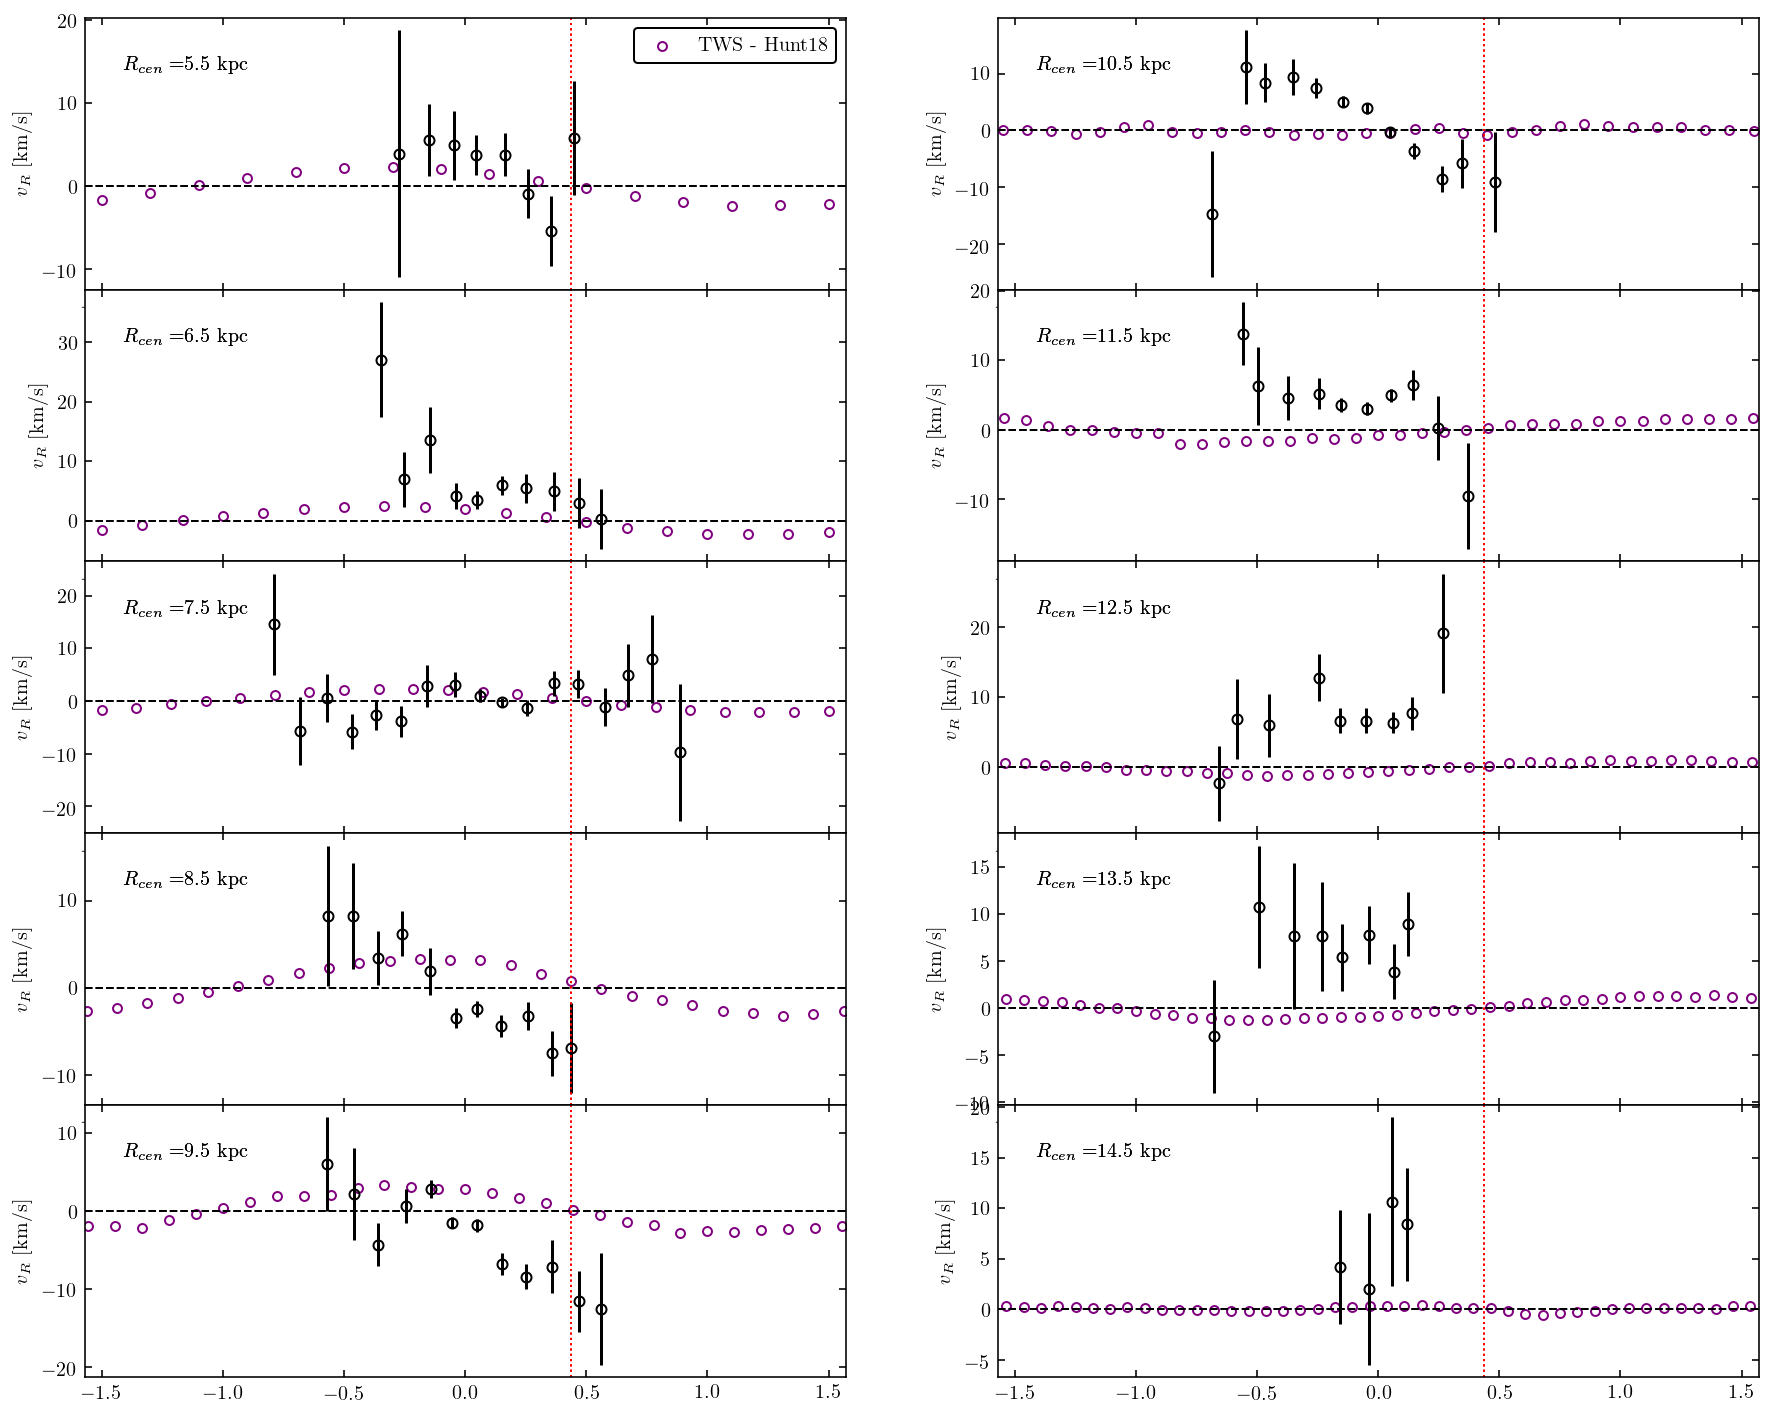

In [99]:
plot_kws_tws={'facecolor':'White', 'edgecolor':'Purple', 's':20}
fig,axs = lm_tws.plot_velocity_known_m_b_phi(velocity_type='vR',plot_best_fit=False, 
                                            plot_errs=False, plot_kws=plot_kws_tws,
                                            twocolumn=True)

fig,axs = lm.plot_velocity_known_m_b_phi(velocity_type='vR',plot_best_fit=False, 
                                         fig=fig, axs=axs)

axs[0].get_legend().remove()
tws_pts=axs[0].scatter([],[],**plot_kws_tws)
axs[0].legend(handles=[tws_pts], labels=['TWS - Hunt18'], 
              loc='best')
fig.set_facecolor('White')

# Load Hunt+ 2019 Simulations

In [87]:
vR_hunt2019_samples = pickle.load( open( '../../scripts/mwbub_simulations/vR.p', 'rb' ) )
vT_hunt2019_samples = pickle.load( open( '../../scripts/mwbub_simulations/vT.p', 'rb' ) )

# Radial bin range and size
R_lim = [5,15]
R_bin_size = 1.0
R_bin_cents = np.arange( R_lim[0], R_lim[1], R_bin_size ) + R_bin_size/2

# Phi bin range and size
phi_lim = [-np.pi/2, np.pi/2]
phi_bin_size = np.pi/30
phi_bin_cents = np.arange( phi_lim[0], phi_lim[1], phi_bin_size ) + phi_bin_size/2

# Phib bin range and size
phib_lim = [0, np.pi/2]
phib_bin_size = np.pi/60
phib_bin_cents = np.arange( phib_lim[0], phib_lim[1], phib_bin_size ) + phi_bin_size/2

lm_hunt19 = ast1501.linear_model.LinearModel2(instantiate_method=3, 
         bs_sample_vR=vR_hunt2019_samples, bs_sample_vT=vT_hunt2019_samples,
         R_lims=R_lim, R_bin_size=R_bin_size, phi_lims=phi_lim, phi_bin_size=phi_bin_size,
         phib_bin_size=phib_bin_size, phib_lims=phib_lim,
         vT_prior_path=vT_prior_path)

# lm = ast1501.linear_model.LinearModel2(instantiate_method=1, gc_R=gc_R, 
#     gc_phi=gc_phi, gc_vR=gc_vR, gc_vT=gc_vT, R_lims=R_lim, 
#     R_bin_size=R_bin_size, phi_lims=phi_lim, 
#     phi_bin_size=phi_bin_size, phib_lims=phib_lim,
#     phib_bin_size=phib_bin_size, 
#     vT_prior_path='../../data/linear_model_prior/MWPotential2014_df_vT_data.npy')

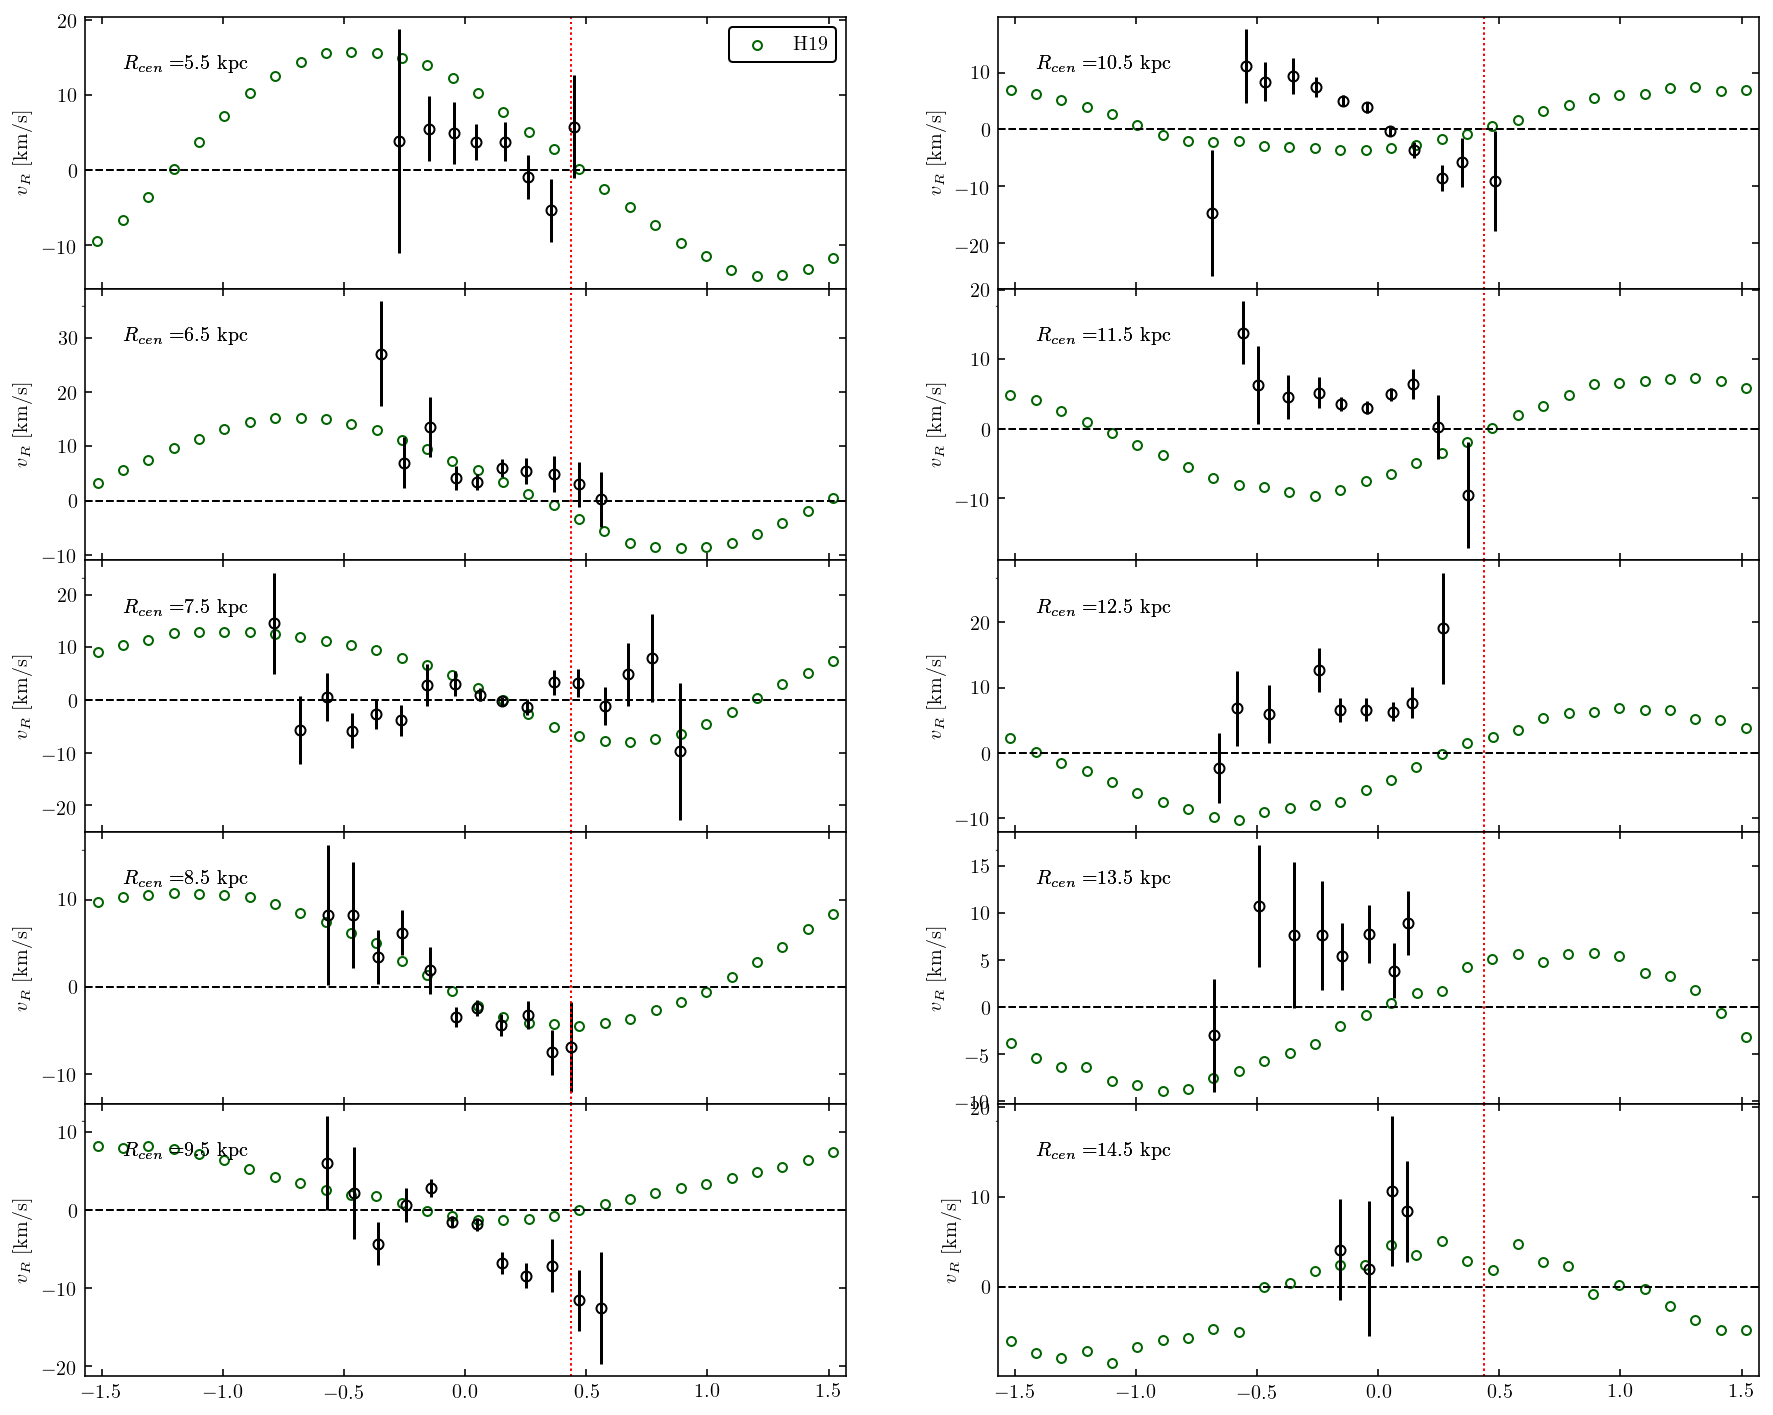

In [92]:
plot_kws_h19={'facecolor':'White', 'edgecolor':'DarkGreen', 's':20}
fig,axs = lm_hunt19.plot_velocity_known_m_b_phi(velocity_type='vR',plot_best_fit=False, 
                                            plot_errs=False, plot_kws=plot_kws_h19, 
                                            twocolumn=True)

fig,axs = lm.plot_velocity_known_m_b_phi(velocity_type='vR',plot_best_fit=False, 
                                         fig=fig, axs=axs)

axs[0].get_legend().remove()
h19_pts=axs[0].scatter([],[],**plot_kws_h19)
axs[0].legend(handles=[h19_pts], labels=['H19'], 
              loc='best')
fig.set_facecolor('White')

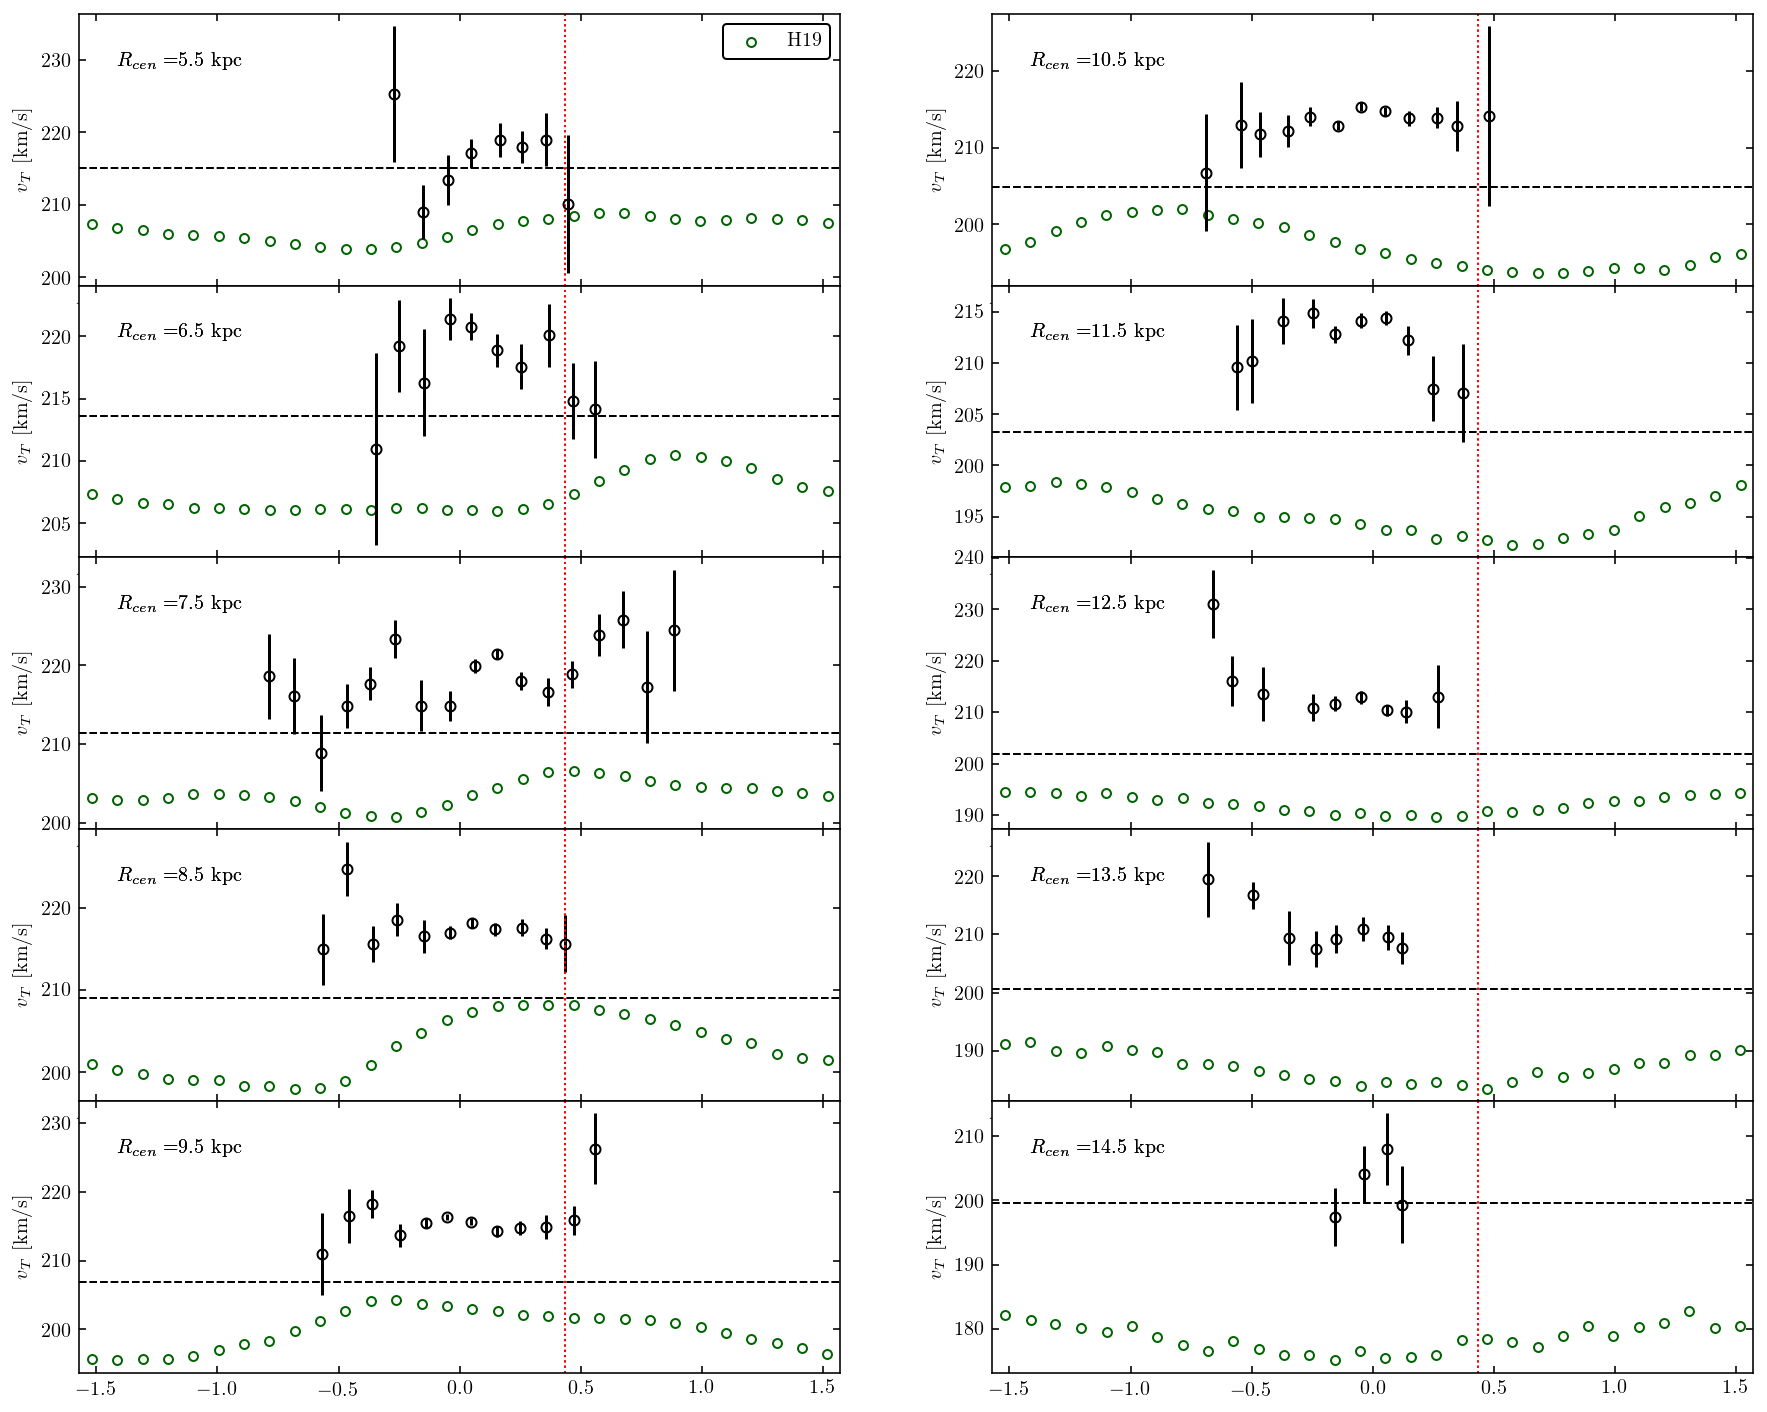

In [93]:
plot_kws_h19={'facecolor':'White', 'edgecolor':'DarkGreen', 's':20}
fig,axs = lm_hunt19.plot_velocity_known_m_b_phi(velocity_type='vT',plot_best_fit=False, 
                                            plot_errs=False, plot_kws=plot_kws_h19, 
                                            twocolumn=True)

fig,axs = lm.plot_velocity_known_m_b_phi(velocity_type='vT',plot_best_fit=False, 
                                         fig=fig, axs=axs)

axs[0].get_legend().remove()
h19_pts=axs[0].scatter([],[],**plot_kws_h19)
axs[0].legend(handles=[h19_pts], labels=['H19'], 
              loc='best')
fig.set_facecolor('White')

In [ ]:
lm_test = ast1501.linear_model.LinearModel(instantiate_method=1, gc_R=gc_R, 
    gc_phi=gc_phi, gc_vR=gc_vR, gc_vT=gc_vT, R_lims=R_lim, 
    R_bin_size=R_bin_size, phi_lims=phi_lim, 
    phi_bin_size=phi_bin_size, phib_lims=phib_lim,
    phib_bin_size=phib_bin_size, force_yint_zero_vR=force_yint_zero,
    use_velocities=['vR','vT'])
fig,axs = lm_test.plot_vRvT_m_r(plot_kws={'markerfacecolor':None,'ecolor':'Black',
    'markeredgecolor':'Black','color':'Black','markersize':10,'marker':'o'})

matplotlib.rc('text', usetex=True)

axs[0,1].set_ylabel(r'$A_{R}$ [km/s]', fontsize=16)
axs[1,1].set_ylabel(r'$A_{T}$ [km/s]', fontsize=16)
axs[0,1].set_xlabel(r'', fontsize=14)
axs[1,1].set_xlabel(r'R [kpc]', fontsize=14)

fig.set_facecolor('White')
plt.savefig('Another_fig_for_talk.png',dpi=300)

plt.show()

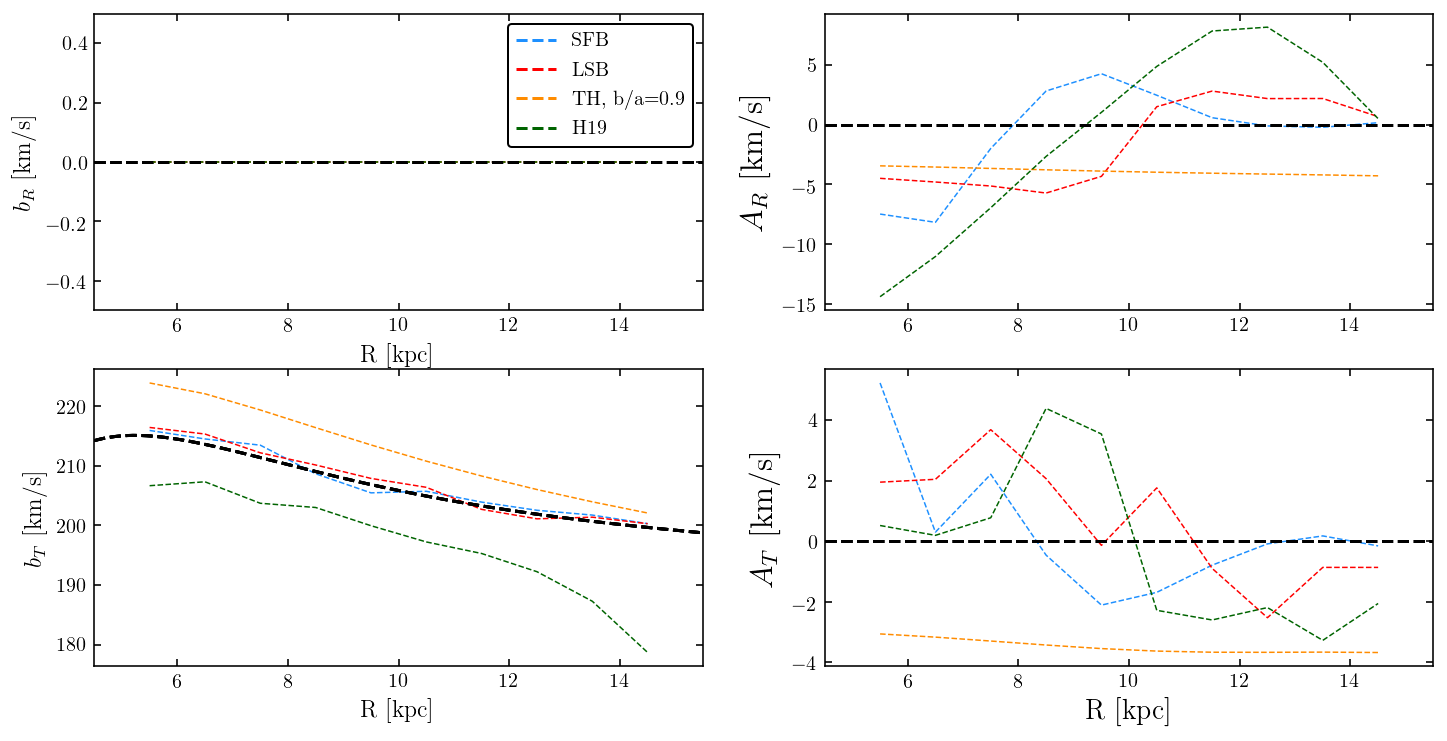

In [90]:
ms=20

# sfb_plot_kws={'ecolor':'Red','marker':'o','markeredgecolor':'Red','color':'Red',
#               'markersize':7,'markerfacecolor':'None','capsize':2,'fmt':'o'}
# sfb_plot_kws={'marker':'o','edgecolor':'Red', 's':ms, 'facecolor':'Red'}
sfb_mb_kws={'color':'DodgerBlue','linewidth':0.75,'linestyle':'dashed'}
fig, axs = lm_sfb.plot_vRvT_m_r(plot_kws=sfb_mb_kws, plot_type='plot')

# lsb_plot_kws={'ecolor':'DodgerBlue','marker':'o','markeredgecolor':'DodgerBlue','color':'DodgerBlue',
#               'markersize':7, 'markerfacecolor':'None','capsize':2,'fmt':'o'}
# lsb_plot_kws={'marker':'o','edgecolor':'DodgerBlue', 's':ms, 'facecolor':'DodgerBlue'}
lsb_mb_kws={'color':'Red','linewidth':0.75,'linestyle':'dashed'}
fig, axs = lm_lsb.plot_vRvT_m_r(plot_kws=lsb_mb_kws, fig=fig, axs=axs, plot_type='plot')

# th_plot_kws={'ecolor':'Black','marker':'o','markeredgecolor':'Black','color':'Black',
#               'markersize':7, 'markerfacecolor':'None','capsize':2,'fmt':'o'}
th_mb_kws={'color':'DarkOrange','linewidth':0.75,'linestyle':'dashed'}
fig, axs = lm_th.plot_vRvT_m_r(plot_kws=th_mb_kws, fig=fig, axs=axs, plot_type='plot')

h19_mb_kws={'color':'DarkGreen','linewidth':0.75,'linestyle':'dashed'}
fig, axs = lm_hunt19.plot_vRvT_m_r(plot_kws=h19_mb_kws, fig=fig, axs=axs, plot_type='plot')



axs[0,0].plot([],[],color='DodgerBlue',linestyle='dashed',label='SFB')
axs[0,0].plot([],[],color='Red',linestyle='dashed',label='LSB')
axs[0,0].plot([],[],color='DarkOrange',linestyle='dashed',label='TH, b/a=0.9')
axs[0,0].plot([],[],color='DarkGreen',linestyle='dashed',label='H19')
axs[0,0].legend()

axs[0,1].set_ylabel(r'$A_{R}$ [km/s]', fontsize=16)
axs[1,1].set_ylabel(r'$A_{T}$ [km/s]', fontsize=16)
axs[0,1].set_xlabel(r'', fontsize=14)
axs[1,1].set_xlabel(r'R [kpc]', fontsize=14)
axs[0,0].set_ylim(-0.5,0.5)

fig.set_facecolor('White')
# plt.savefig('fig_for_talk.png',dpi=300)
# plt.show()
# plt.close('all')

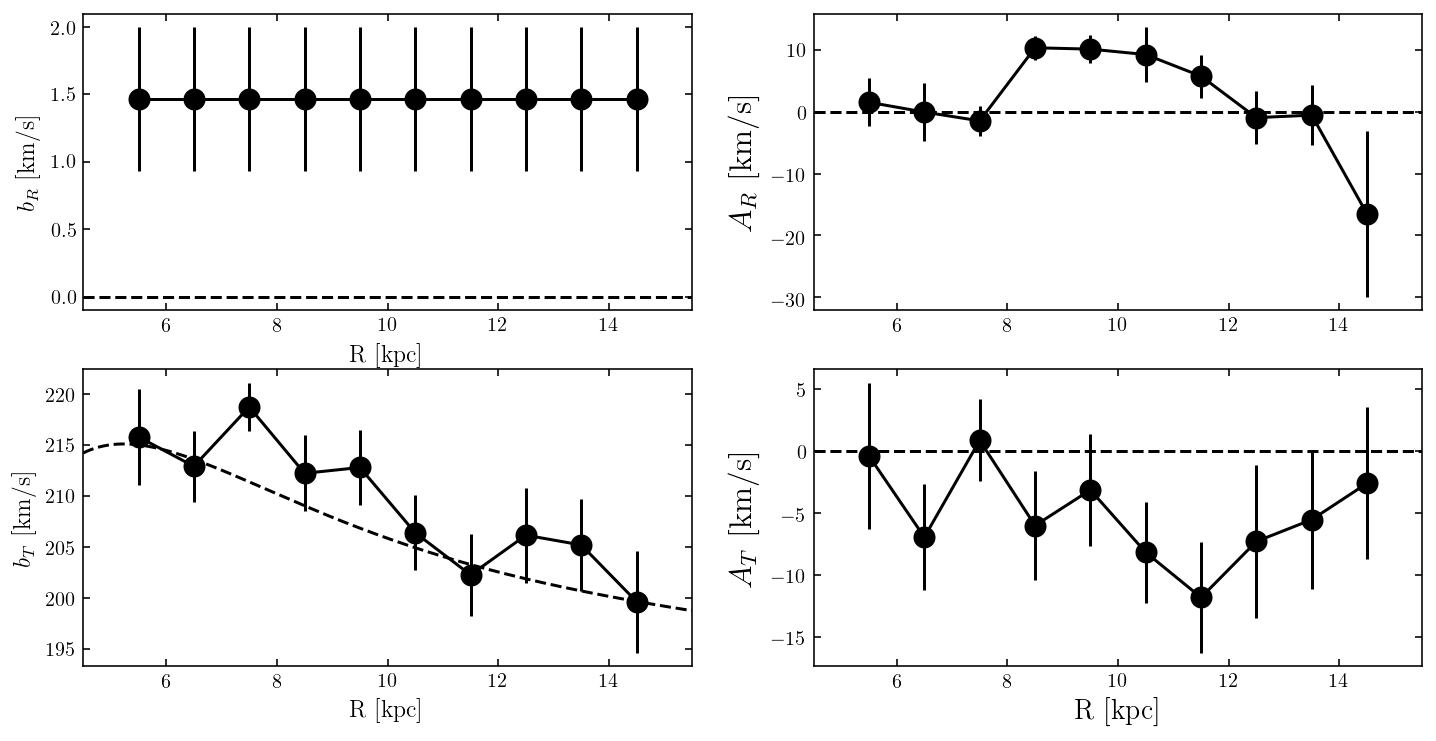

In [91]:
fig,axs = lm.plot_vRvT_m_r(plot_kws={'markerfacecolor':None,'ecolor':'Black',
    'markeredgecolor':'Black','color':'Black','markersize':10,'marker':'o'})

matplotlib.rc('text', usetex=True)

axs[0,1].set_ylabel(r'$A_{R}$ [km/s]', fontsize=16)
axs[1,1].set_ylabel(r'$A_{T}$ [km/s]', fontsize=16)
axs[0,1].set_xlabel(r'', fontsize=14)
axs[1,1].set_xlabel(r'R [kpc]', fontsize=14)

fig.set_facecolor('White')

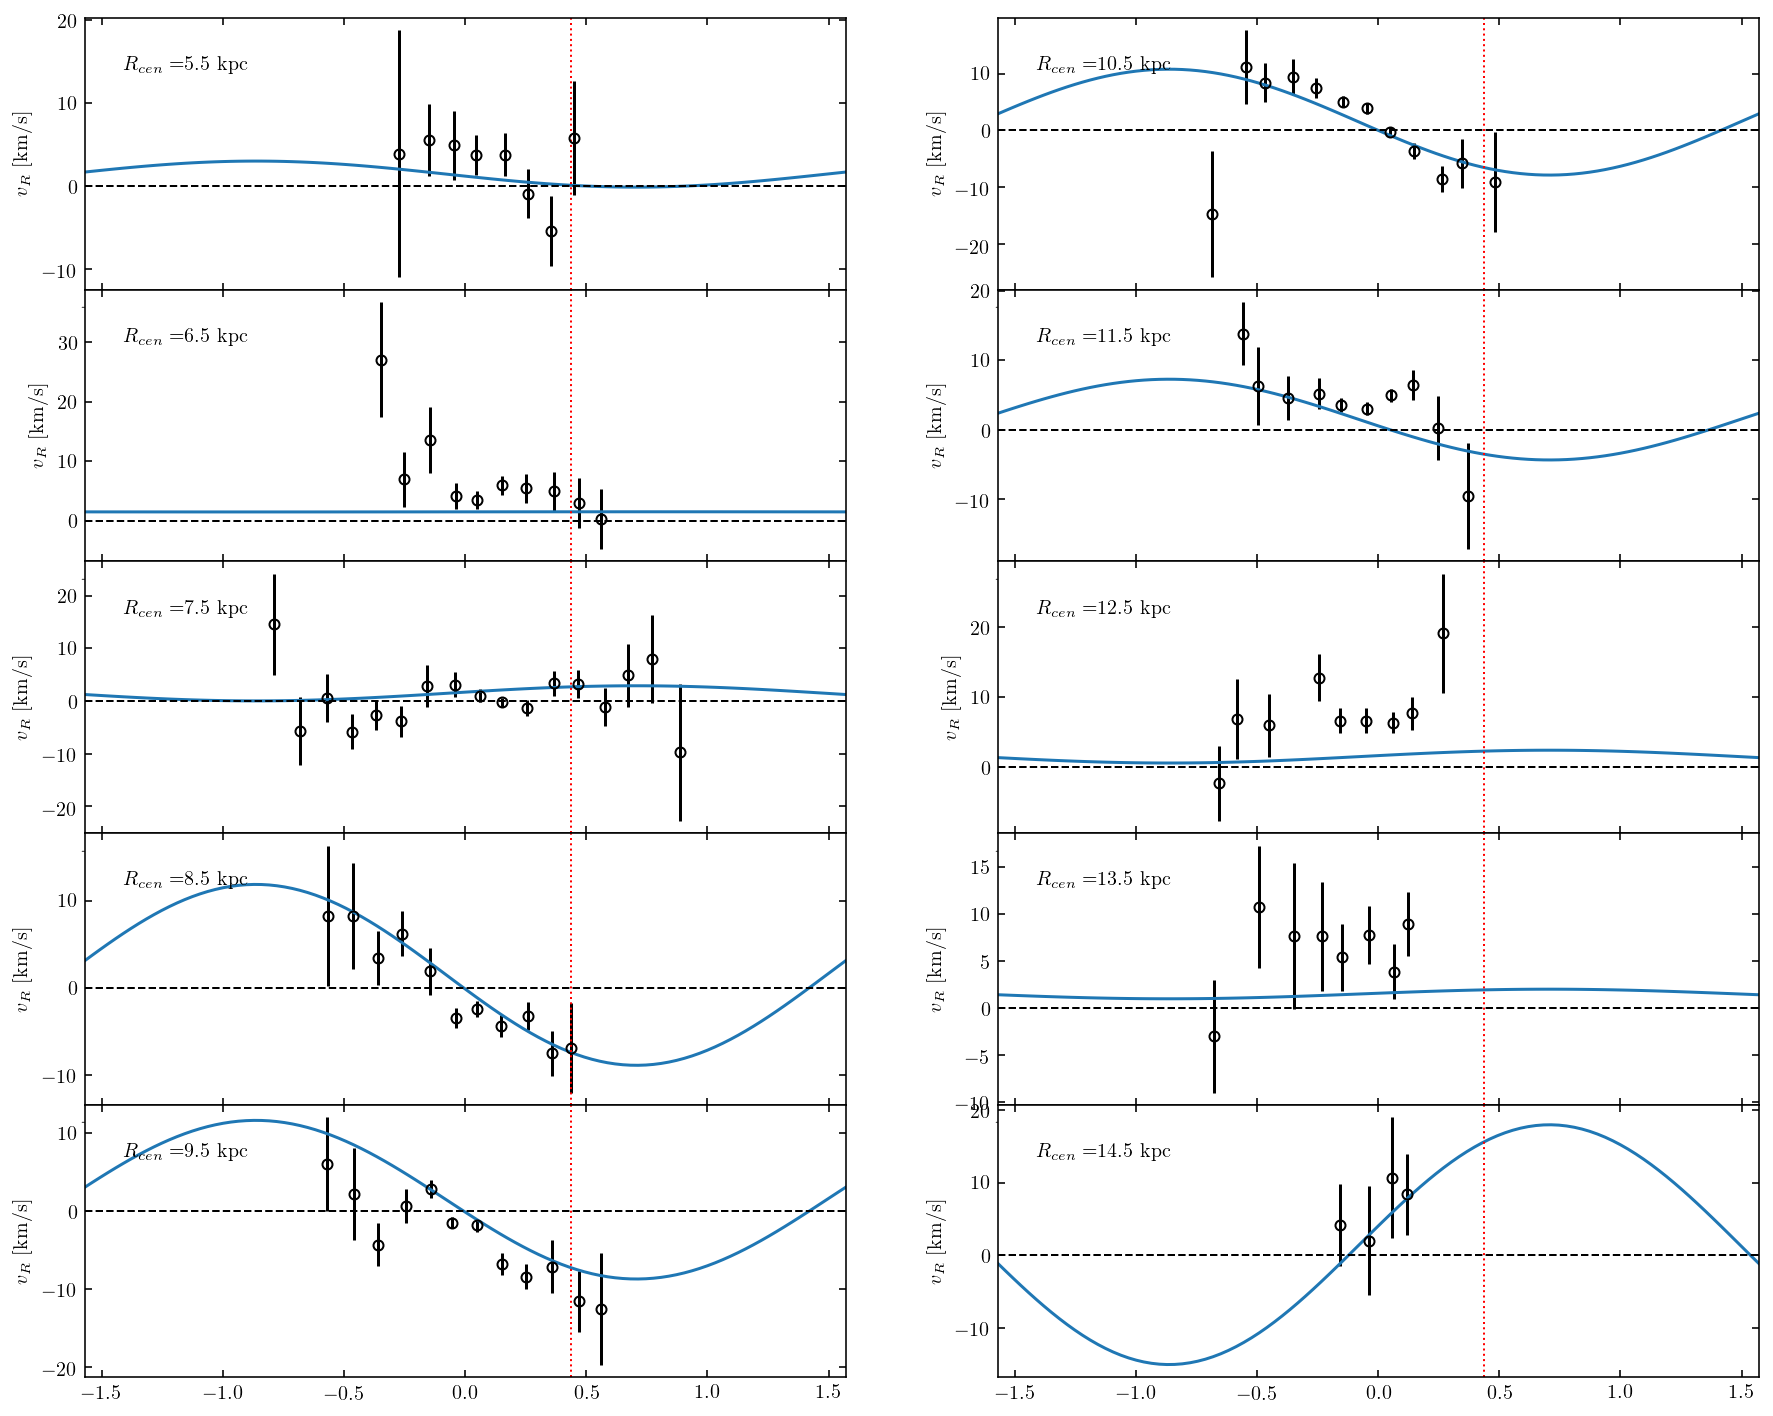

In [96]:
fig,axs = lm.plot_velocity_known_m_b_phi(velocity_type='vR',plot_best_fit=True)

axs[0].get_legend().remove()
fig.set_facecolor('White')

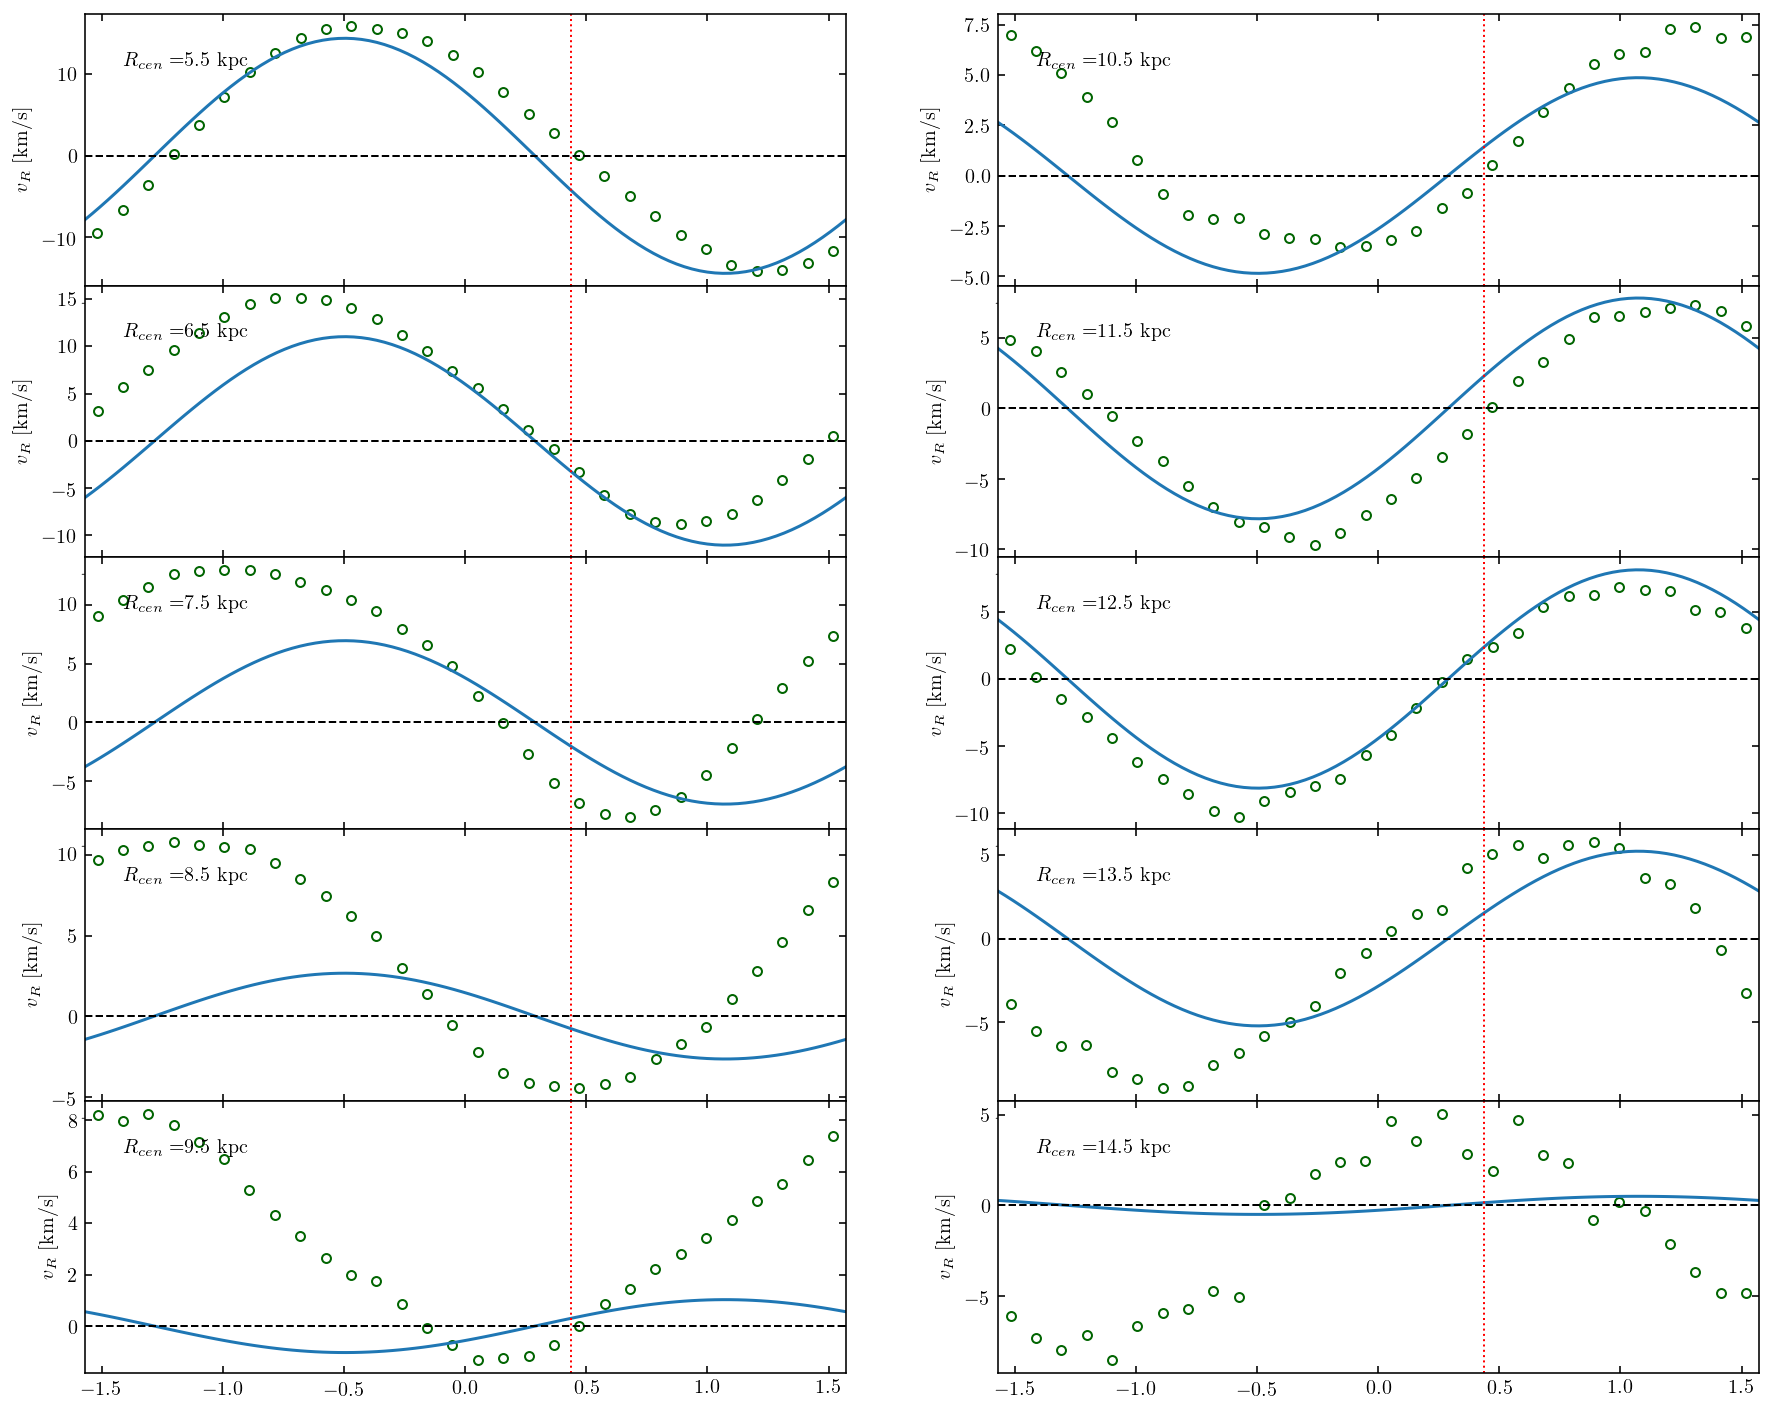

In [97]:
plot_kws_h19={'facecolor':'White', 'edgecolor':'DarkGreen', 's':20}
fig,axs = lm_hunt19.plot_velocity_known_m_b_phi(velocity_type='vR',plot_best_fit=True, 
                                            plot_errs=False, plot_kws=plot_kws_h19, 
                                            twocolumn=True)

axs[0].get_legend().remove()
fig.set_facecolor('White')